In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import re

def extract_seed_lengths_from_dir(data_dir):
    seed_lengths = []
    pattern = re.compile(r"HL(\d+)\.json")
    for filename in os.listdir(data_dir):
        match = pattern.match(filename)
        if match:
            seed_lengths.append(int(match.group(1)))
    return sorted(seed_lengths)

def get_best_metric(metric_name, data_dir, seed_lengths):
    best_argmax = []
    best_softmax = []
    best_softmax_labels = []
    best_argmax_epochs = []
    best_softmax_epochs = []

    for hl in seed_lengths:
        file_path = os.path.join(data_dir, f"HL{hl}.json")
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        with open(file_path, "r") as f:
            data = json.load(f)

        max_argmax = -1
        max_softmax = -1
        max_temp_label = None
        argmax_epoch = -1
        softmax_epoch = -1

        for epoch_str, epoch_data in data.items():
            epoch = int(epoch_str)

            # Argmax
            if "argmax" in epoch_data:
                val = epoch_data["argmax"].get(f"{metric_name}_mean", 0)
                if val > max_argmax:
                    max_argmax = val
                    argmax_epoch = epoch

            # Softmax temps
            for key, val_dict in epoch_data.items():
                if key.startswith("temp="):
                    val = val_dict.get(f"{metric_name}_mean", 0)
                    if val > max_softmax:
                        max_softmax = val
                        max_temp_label = key
                        softmax_epoch = epoch

        best_argmax.append(max_argmax)
        best_softmax.append(max_softmax)
        best_softmax_labels.append(max_temp_label)
        best_argmax_epochs.append(argmax_epoch)
        best_softmax_epochs.append(softmax_epoch)

    return best_argmax, best_argmax_epochs, best_softmax, best_softmax_labels, best_softmax_epochs

def plot_metric(metric_name, ylabel, title, data_dir, seed_lengths):
    best_argmax, argmax_epochs, best_softmax, softmax_labels, softmax_epochs = get_best_metric(metric_name, data_dir, seed_lengths)
    x = np.arange(len(seed_lengths))
    width = 0.35

    fig, ax = plt.subplots(figsize=(13, 6))
    bar1 = ax.bar(x - width / 2, best_argmax, width, label='Argmax')
    bar2 = ax.bar(x + width / 2, best_softmax, width, label='Softmax-Temp')

    # Add bar height (metric value) on top
    for rect in bar1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, height, f"{height:.3f}", ha='center', va='bottom', fontsize=8)
    for rect in bar2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, height, f"{height:.3f}", ha='center', va='bottom', fontsize=8)

    # Add epoch below bars, right above the x-axis
    for i, (epoch_a, epoch_s, label_s) in enumerate(zip(argmax_epochs, softmax_epochs, softmax_labels)):
        ax.text(x[i] - width / 2, 0, f"step={epoch_a}", ha='center', va='top', fontsize=8, rotation=0)
        ax.text(x[i] + width / 2, 0, f"{label_s}\nstep={epoch_s}", ha='center', va='top', fontsize=8, rotation=0)

    ax.set_xlabel('Seed Length')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(seed_lengths)
    ax.legend()

    plt.tight_layout()
    plt.show()

# # Set the directory containing the HL*.json files
# data_dir = "./sibling_discovery/results/P5-C2500-prob1-H26-N50000-E30-new_eval_nucleus_1.0-plan"  # Change this if needed
# data_dir = "./sibling_discovery/results/P5-C2500-prob1-H26-N50000-E30-dense-plan"

# seed_lengths = extract_seed_lengths_from_dir(data_dir)

# # Plot for Representation Power
# plot_metric("rep_power", "Memorization", "Memorization vs Seed Length (No Planning)", data_dir, seed_lengths)  

# # Plot for Creativity
# plot_metric("creativity", "Creativity", "Creativity vs Seed Length (No Planning)", data_dir, seed_lengths)

# # Plot for Uniqueness
# plot_metric("uniqueness", "Uniqueness", "Uniqueness vs Seed Length (No Planning)", data_dir, seed_lengths)


In [2]:
def load_all_metrics(data_dir, metric_name):
    seed_lengths = extract_seed_lengths_from_dir(data_dir)
    temp_values = set()
    results = {}  # {temp: {seed_length: (epochs, metric_values)}}

    for hl in seed_lengths:
        file_path = os.path.join(data_dir, f"HL{hl}.json")
        if not os.path.exists(file_path):
            continue
        with open(file_path, "r") as f:
            data = json.load(f)

        # Gather values per temp or "argmax"
        temp_to_values = {}
        for epoch_str, epoch_data in data.items():
            epoch = int(epoch_str)
            for key, val_dict in epoch_data.items():
                if key == "argmax" or key.startswith("temp="):
                    metric_val = val_dict.get(f"{metric_name}_mean")
                    if metric_val is None:
                        continue
                    if key not in temp_to_values:
                        temp_to_values[key] = []
                    temp_to_values[key].append((epoch, metric_val))

        # Organize for plotting
        for temp, points in temp_to_values.items():
            points = sorted(points)
            epochs = [ep for ep, _ in points]
            values = [val for _, val in points]
            if temp not in results:
                results[temp] = {}
            results[temp][hl] = (epochs, values)
            temp_values.add(temp)

    return results, sorted(temp_values)

def plot_metric_with_subplots(metric_name, ylabel, title, data_dir):
    results, temp_keys = load_all_metrics(data_dir, metric_name)

    num_cols = 3
    num_rows = (len(temp_keys) + num_cols - 1) // num_cols

    # fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows), sharey=True)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
    axs = axs.flatten()

    colors = plt.cm.viridis_r
    seed_lengths = sorted({hl for temp in results.values() for hl in temp})

    for i, temp in enumerate(temp_keys):
        ax = axs[i]
        for j, hl in enumerate(seed_lengths):
            if hl not in results[temp]:
                continue
            epochs, values = results[temp][hl]
            ax.plot(epochs, values, label=f"HL={hl}", color=colors(j / len(seed_lengths)))

        ax.set_title(temp)
        ax.set_xlabel("Step")
        ax.set_ylabel(ylabel)
        ax.legend(fontsize=8)

    for k in range(len(temp_keys), len(axs)):
        axs[k].axis("off")

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


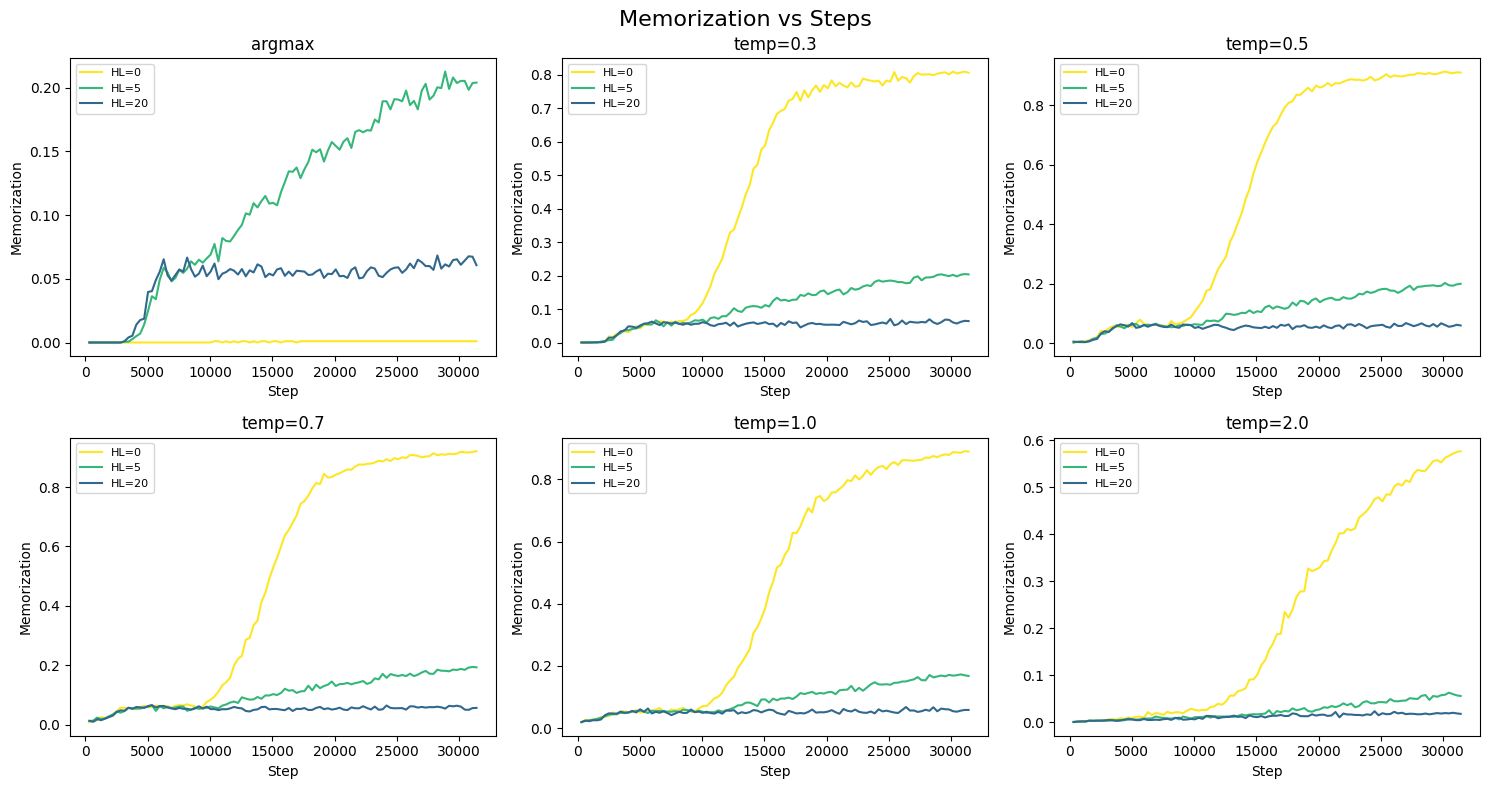

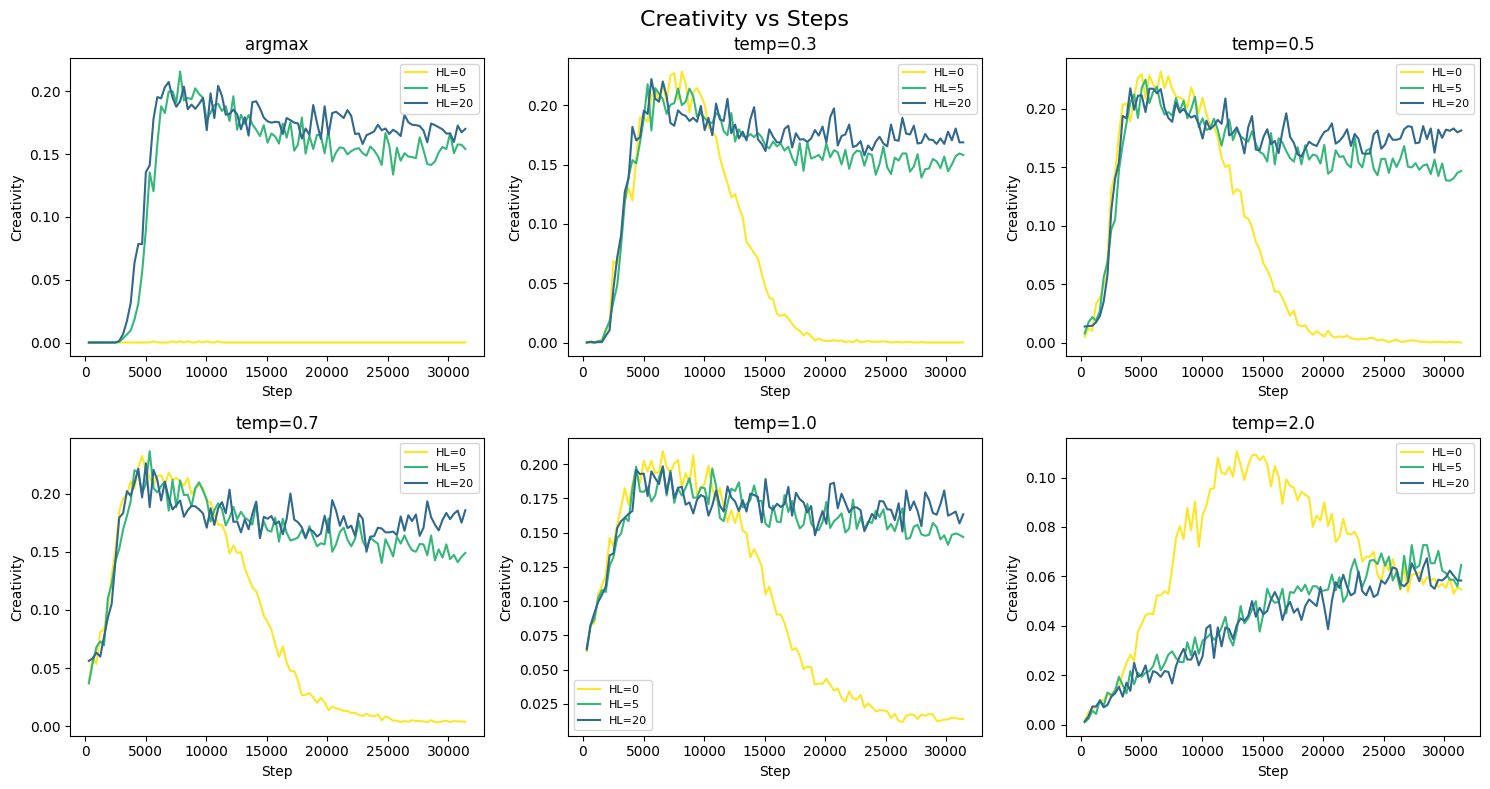

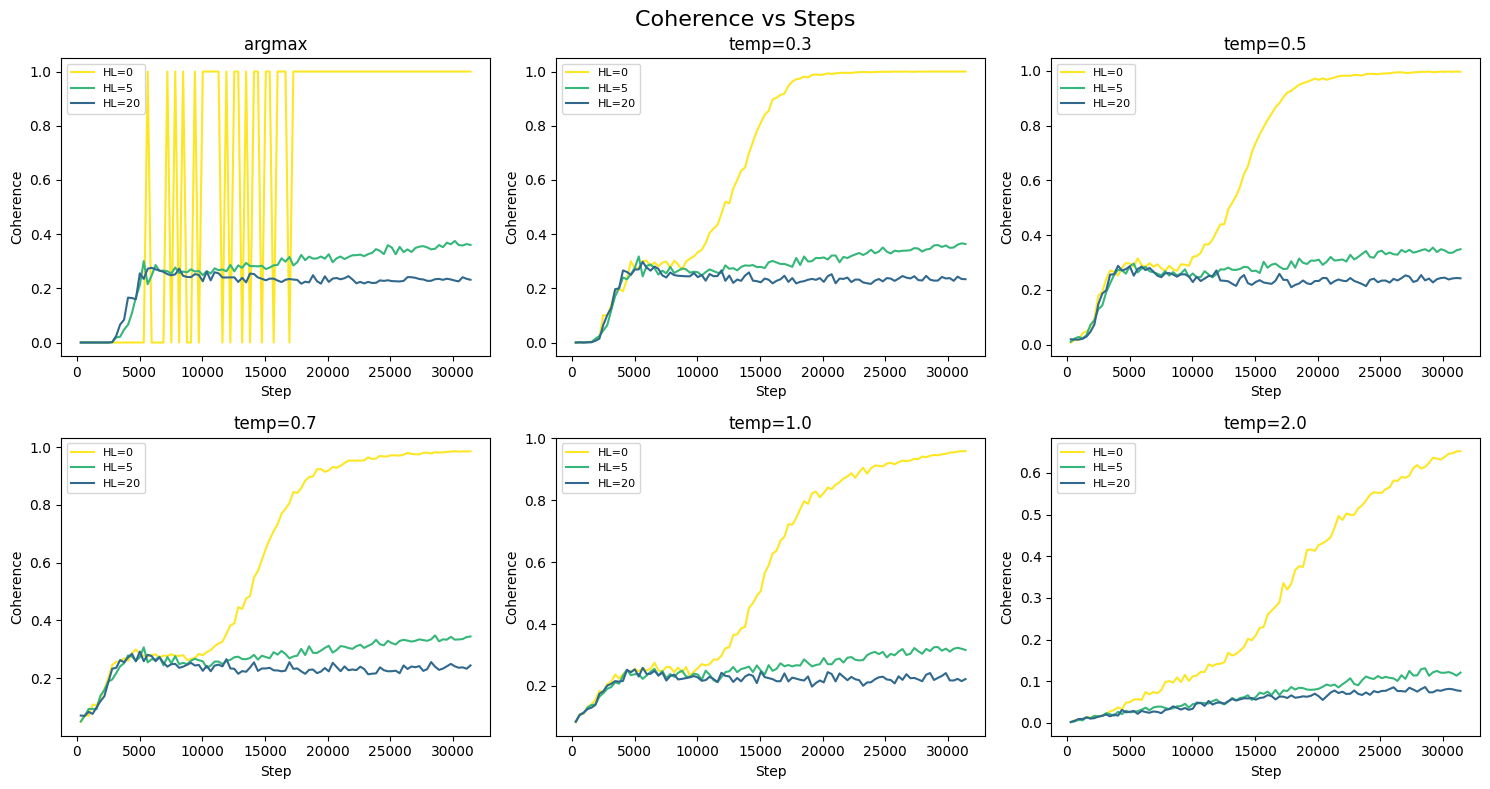

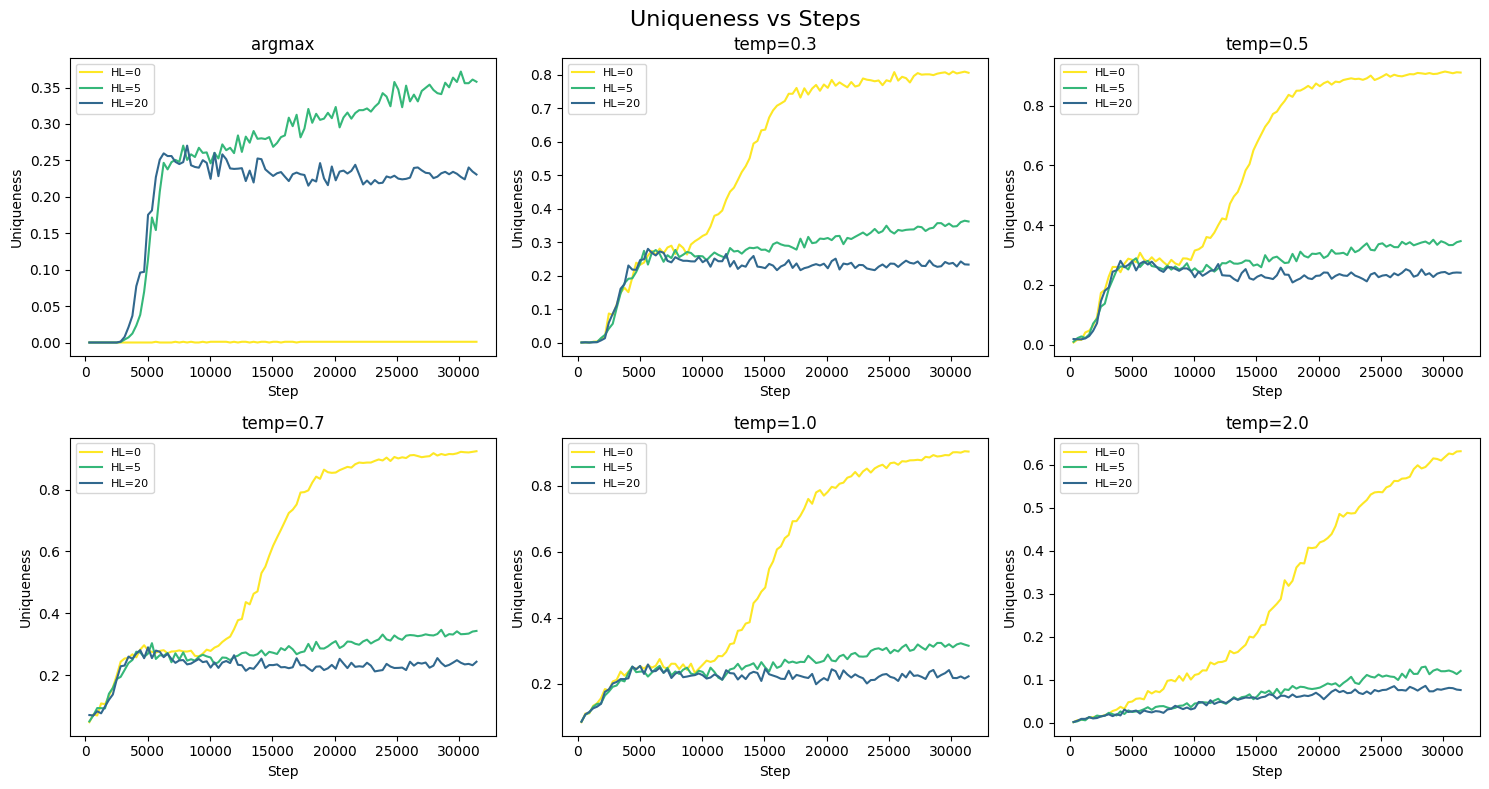

In [7]:
# data_dir = "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H300-NT10000-E200-top_p1.0-gemma-2b-pretrained"  
# data_dir = "/datastor1/vansh/lang_sampling/results/circle/M30-N18-H26-NT50000-E200-top_p1.0-gemma-2b-pretrained"
# data_dir = "/datastor1/vansh/lang_sampling/results/sibling/P5-C2500-prob1-H26-N10000-E70-top_p1.0-gemma-2b-pretrained-att_viz-plan"
# data_dir = "./sibling_discovery/results/P5-C2500-prob1-H26-N50000-E30-new_eval_no_logit_processor-plan"  # Change this if needed
# data_dir = "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H300-NT10000-E200-top_p1.0-gemma-2b-pretrained-LR5e-5-SEED20"
data_dir = "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-E200-top_p1.0-gpt2-large-pretrained-BS32-LR5e-5-RNG20"
# data_dir = "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-E100-top_p1.0-gemma-2b-pretrained-BS32-LR5e-5-RNG20"
data_dir = "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-top_p1.0-gpt2-custom-default-BS64-LR5e-5-E200-RNG20-TOKcustom"

plot_metric_with_subplots("rep_power", "Memorization", "Memorization vs Steps", data_dir)
plot_metric_with_subplots("creativity", "Creativity", "Creativity vs Steps", data_dir)
plot_metric_with_subplots("coherence", "Coherence", "Coherence vs Steps", data_dir)
plot_metric_with_subplots("uniqueness", "Uniqueness", "Uniqueness vs Steps", data_dir)

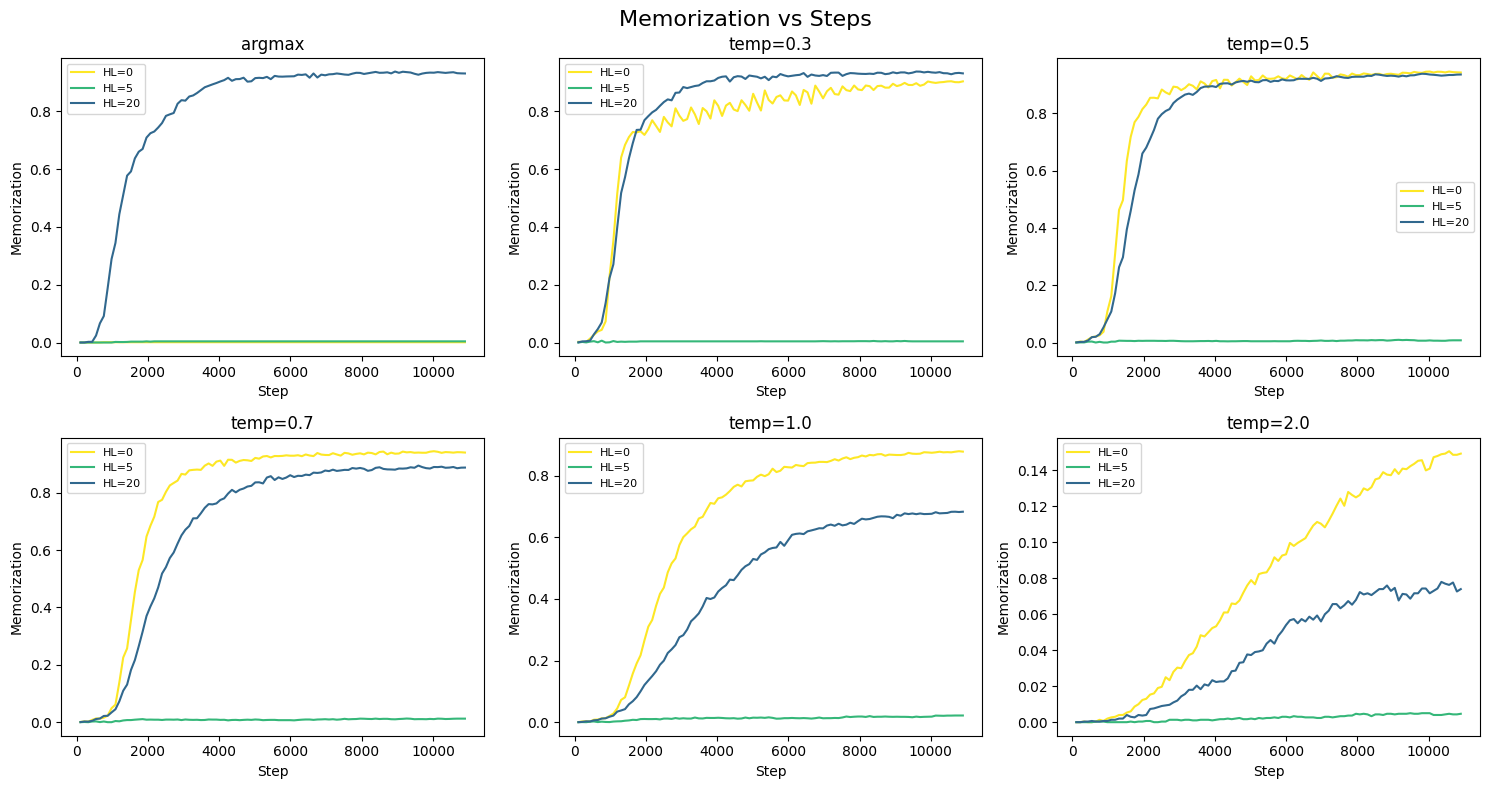

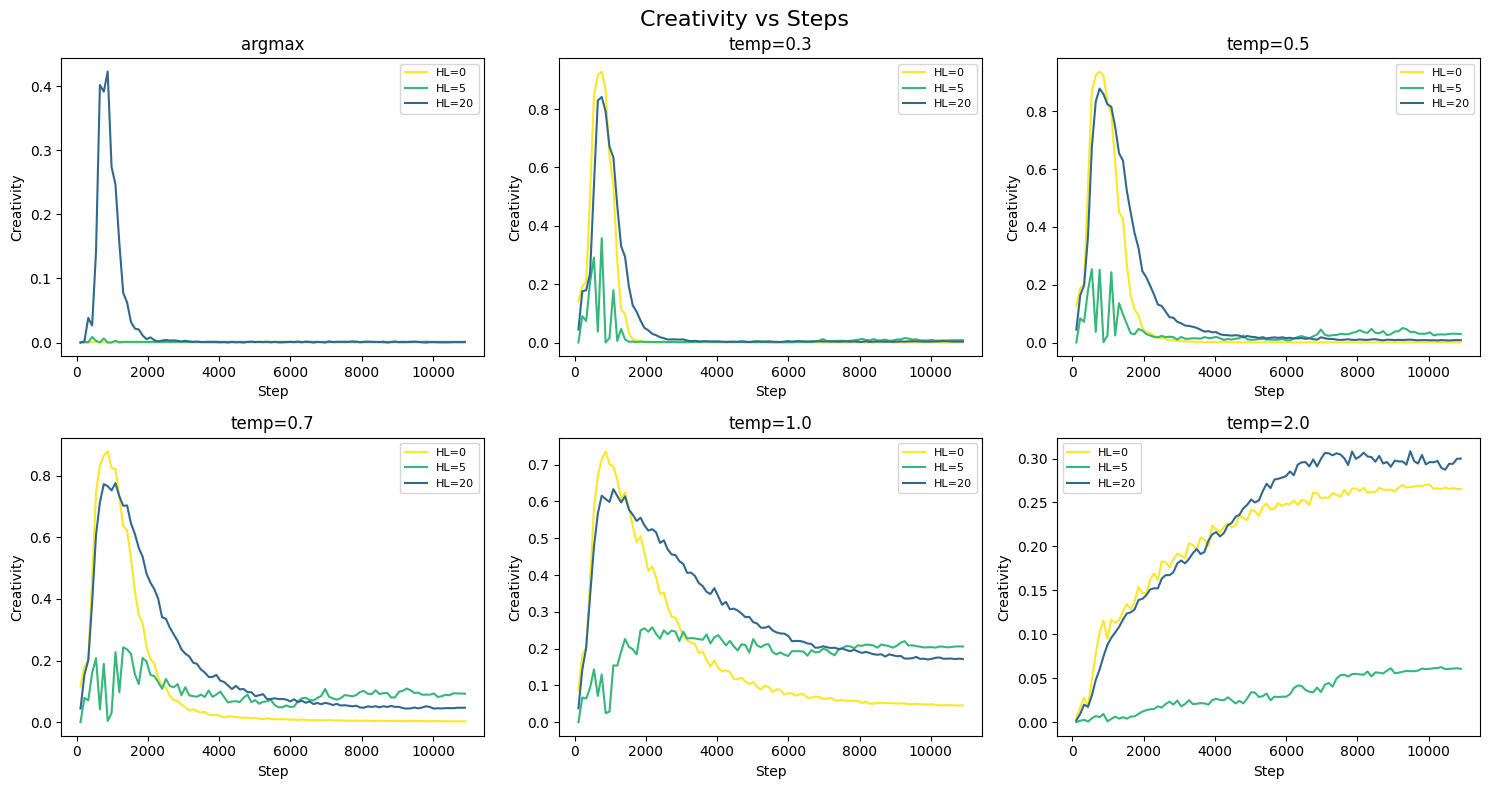

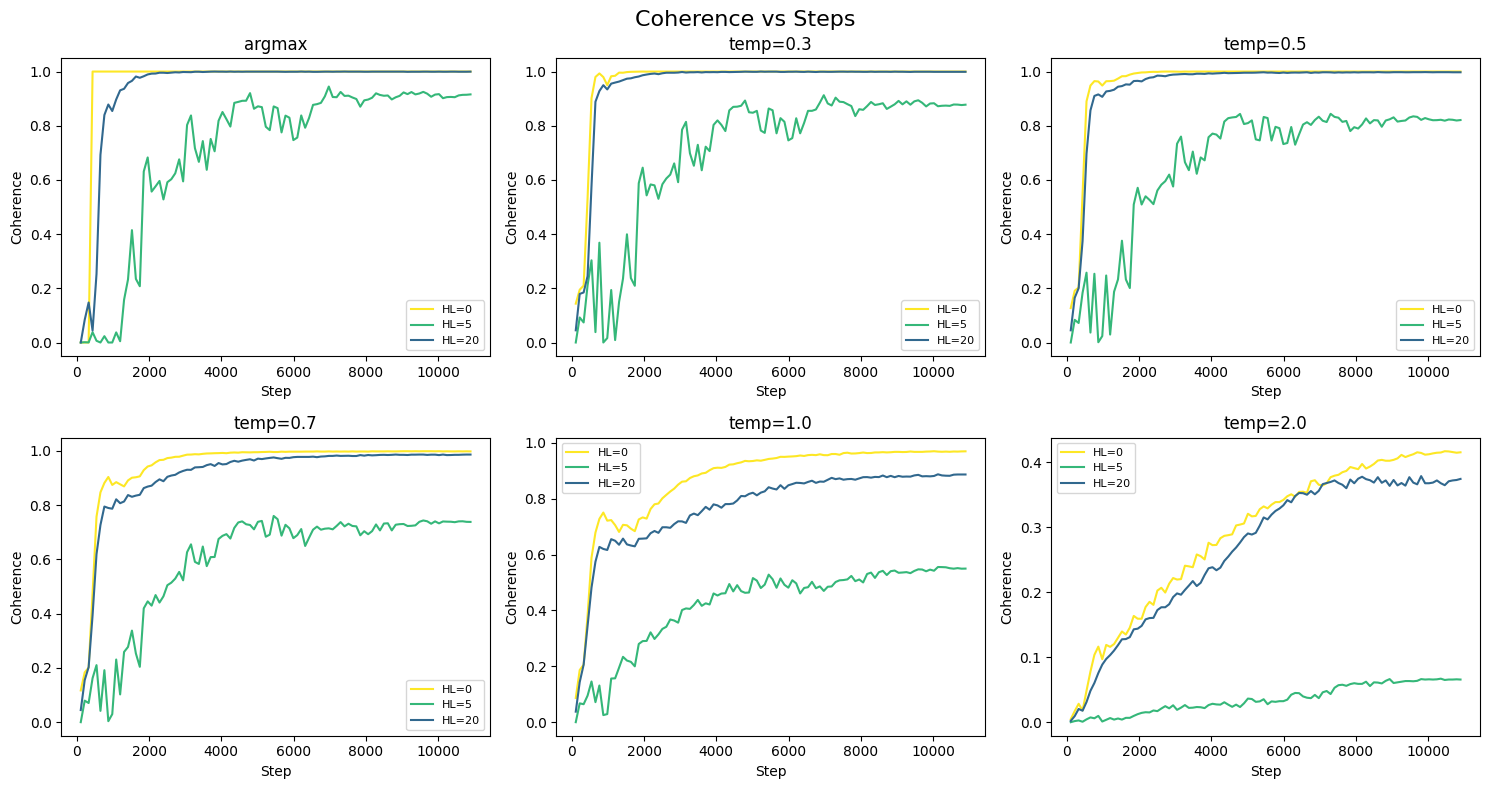

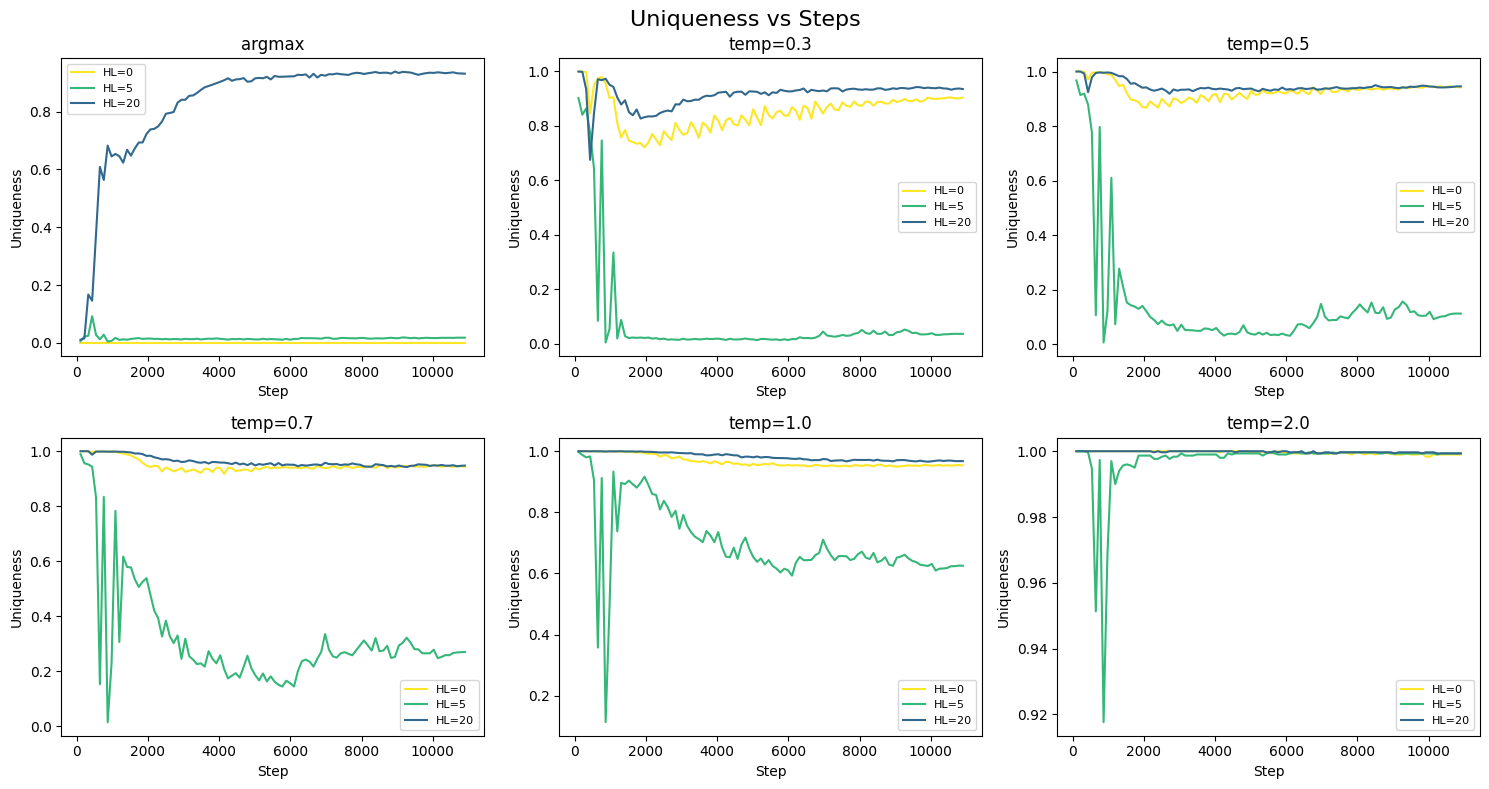

In [6]:
data_dir = "/datastor1/vansh/lang_sampling/results/sibling/P5-C2500-prob1-H26-N10000-E70-top_p1.0-gemma-2b-pretrained-plan"  # Change this if needed
# data_dir = "/datastor1/vansh/lang_sampling/old_results/sibling/P5-C2500-prob1-H26-N10000-E70-top_p1.0-gemma-2b-pretrained-BS64-LR1e-4-att_viz-plan"
data_dir = "/datastor1/vansh/lang_sampling/results/sibling/P5-C2500-prob1-H26-N10000-E70-top_p1.0-gemma-2b-pretrained-BS64-LR1e-4-SEED20-plan"
# data_dir = "/datastor1/vansh/lang_sampling/old_results/sibling/P5-C2500-prob1-H26-N10000-E70-top_p1.0-gemma-2b-pretrained-BS64-att_viz-no_new_vocab-plan"
data_dir = "/datastor1/vansh/lang_sampling/results/sibling/P5-C2500-prob1-H26-N10000-E70-top_p1.0-gpt2-pretrained-BS64-LR5e-5-RNG20-new_tokens-plan"

data_dir = "/datastor1/vansh/lang_sampling/results/sibling/P5-C2500-prob1-H26-N10000-top_p1.0-gpt2-custom-default-BS64-LR5e-5-E70-RNG20-TOKcustom-plan"

plot_metric_with_subplots("rep_power", "Memorization", "Memorization vs Steps", data_dir)
plot_metric_with_subplots("creativity", "Creativity", "Creativity vs Steps", data_dir)
plot_metric_with_subplots("coherence", "Coherence", "Coherence vs Steps", data_dir)
plot_metric_with_subplots("uniqueness", "Uniqueness", "Uniqueness vs Steps", data_dir)

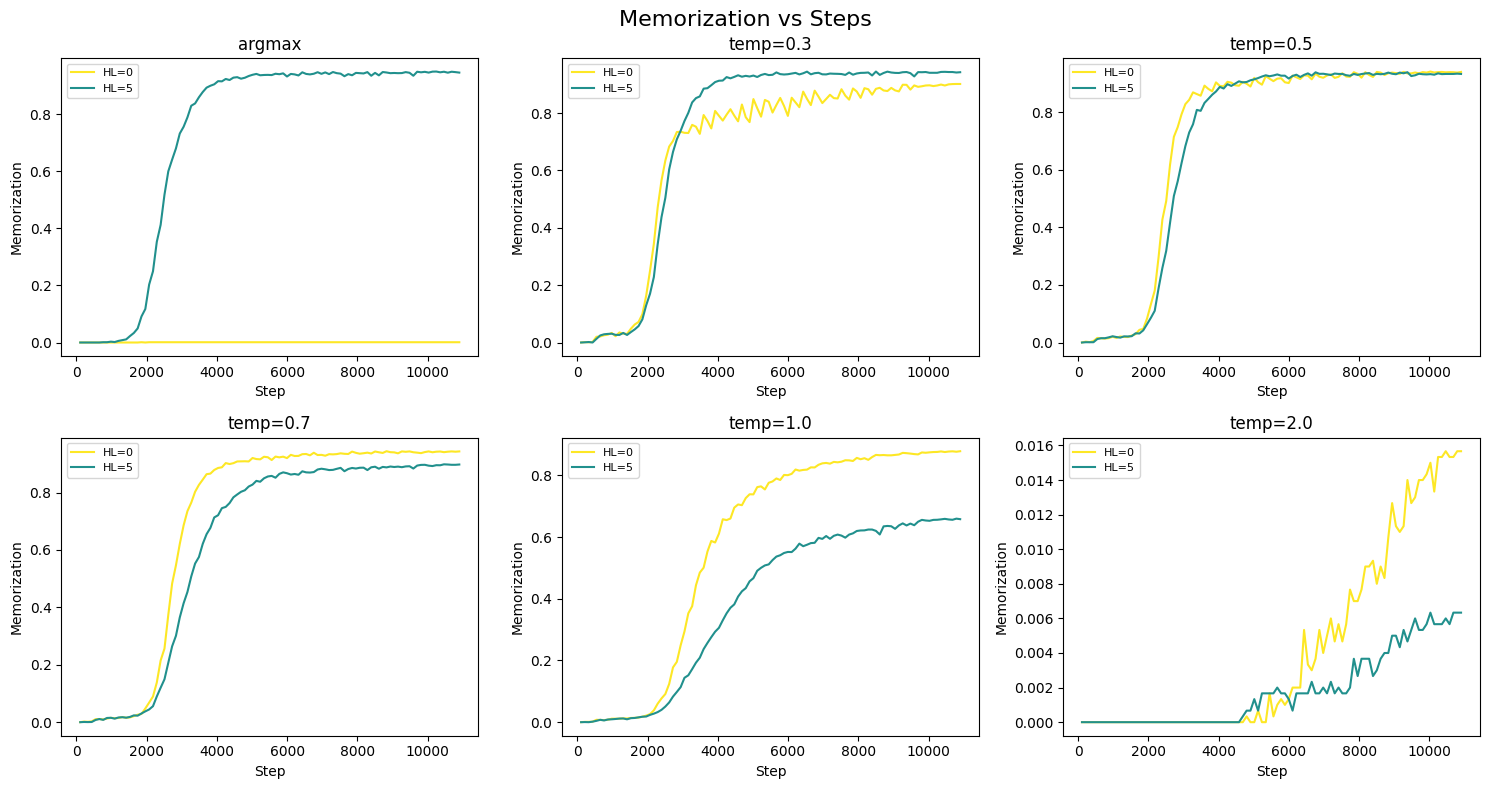

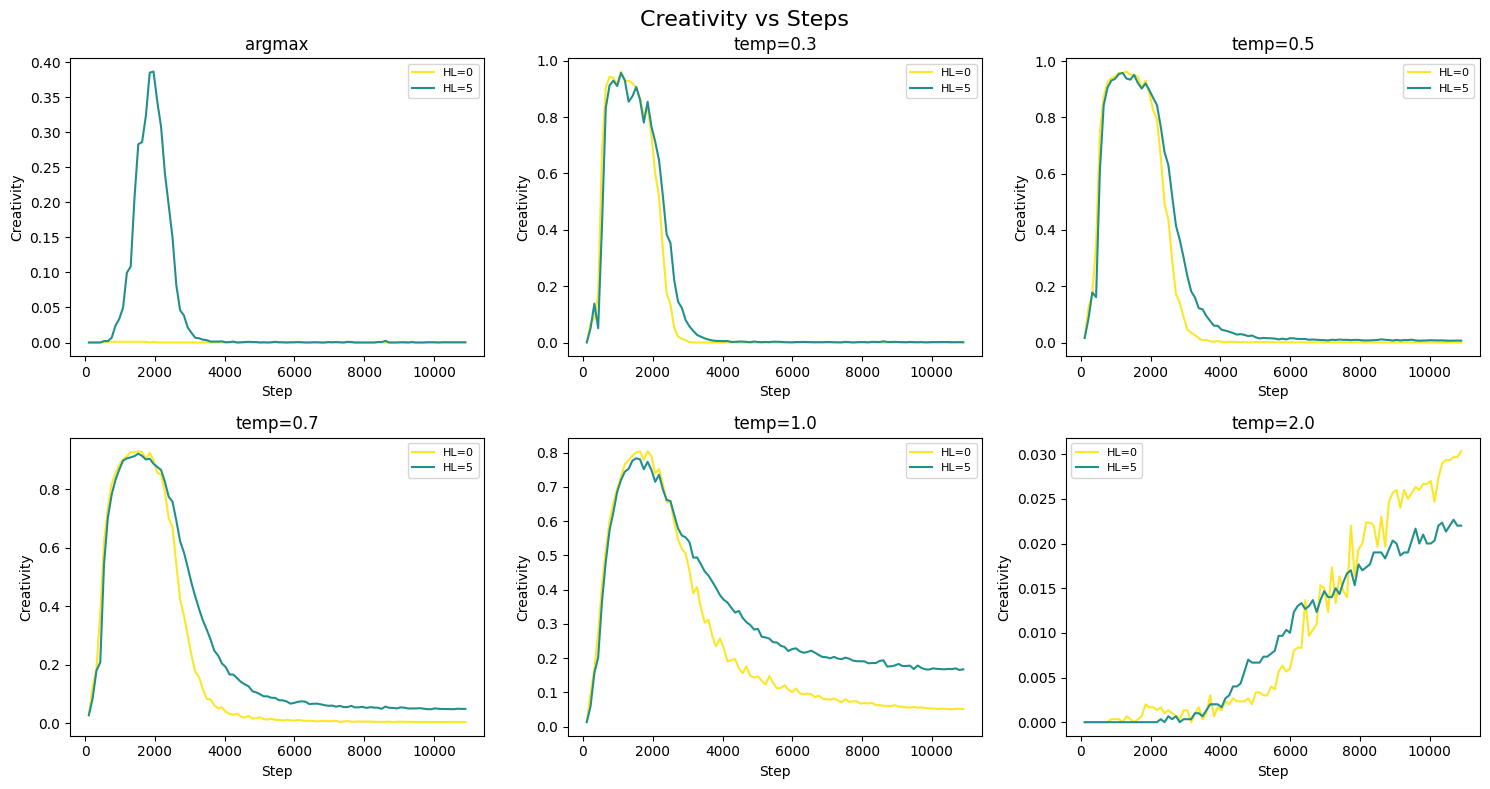

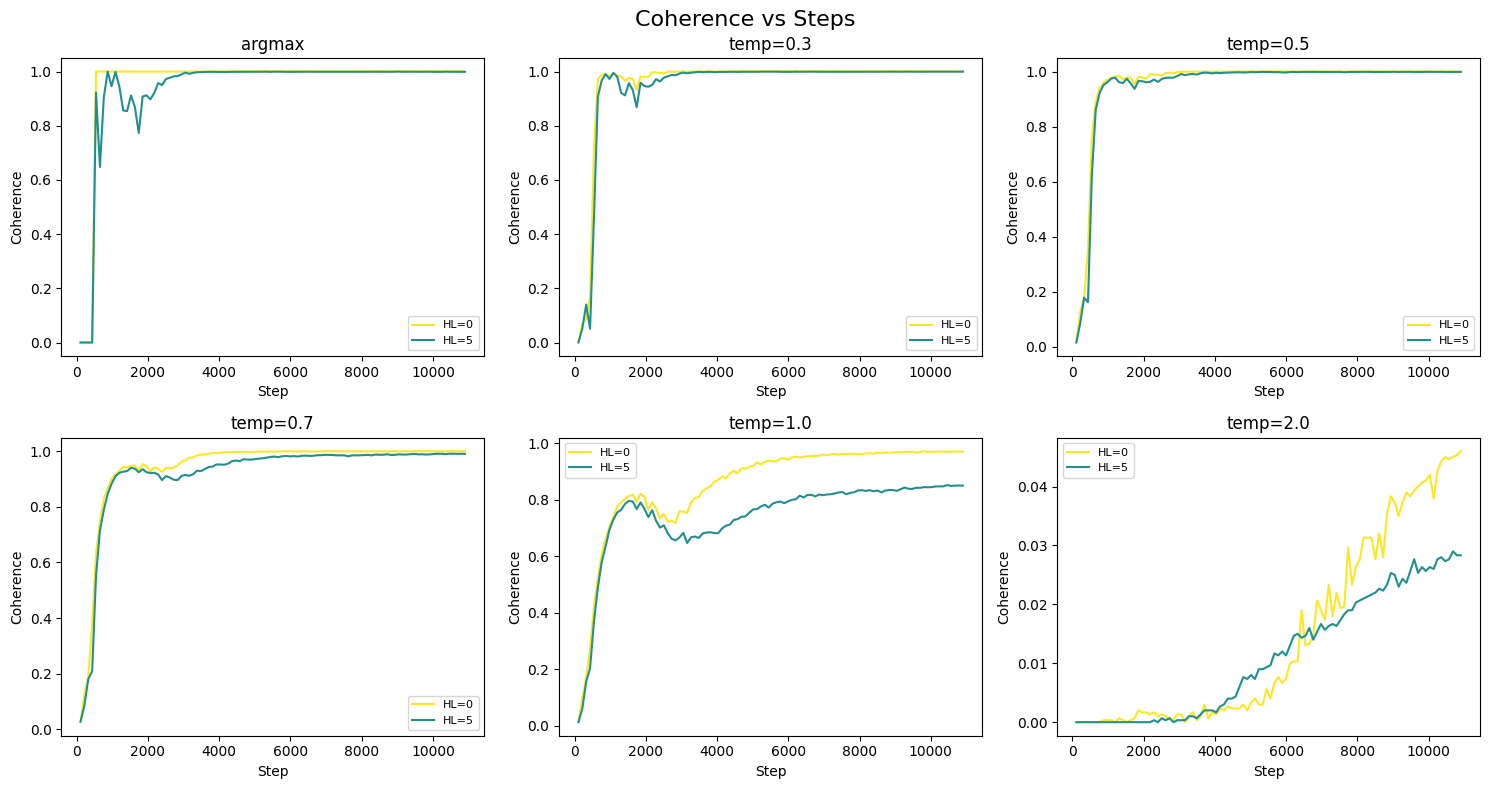

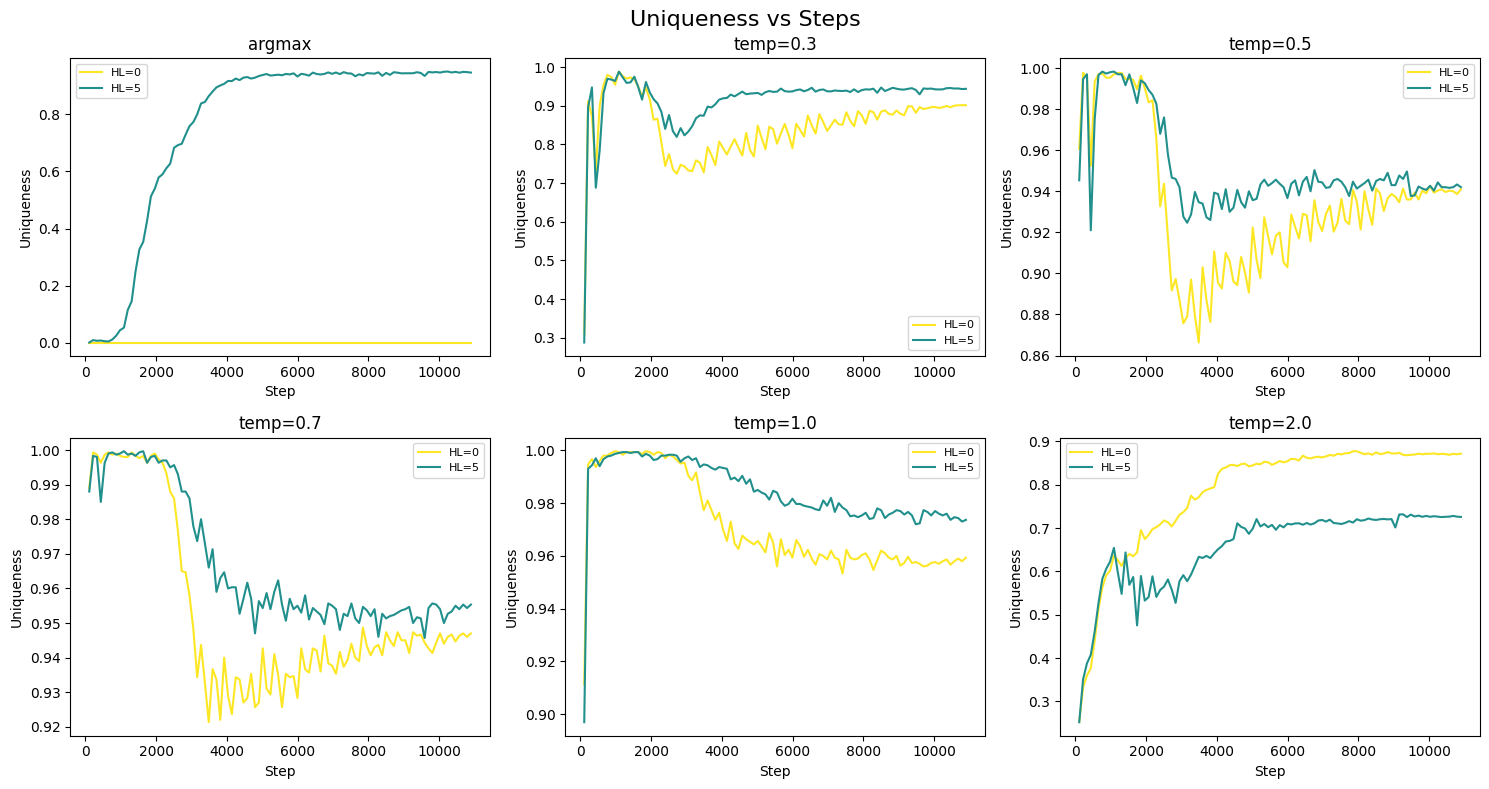

In [9]:
data_dir = "/datastor1/vansh/lang_sampling/results/sibling/P5-C2500-prob1-H26-N10000-E70-top_p1.0-gpt2-att_viz-plan"  # Change this if needed

# data_dir = "./sibling_discovery/results/P5-C2500-prob1-H26-N50000-E30-new_eval_no_logit_processor-plan"  # Change this if needed
plot_metric_with_subplots("rep_power", "Memorization", "Memorization vs Steps", data_dir)
plot_metric_with_subplots("creativity", "Creativity", "Creativity vs Steps", data_dir)
plot_metric_with_subplots("coherence", "Coherence", "Coherence vs Steps", data_dir)
plot_metric_with_subplots("uniqueness", "Uniqueness", "Uniqueness vs Steps", data_dir)

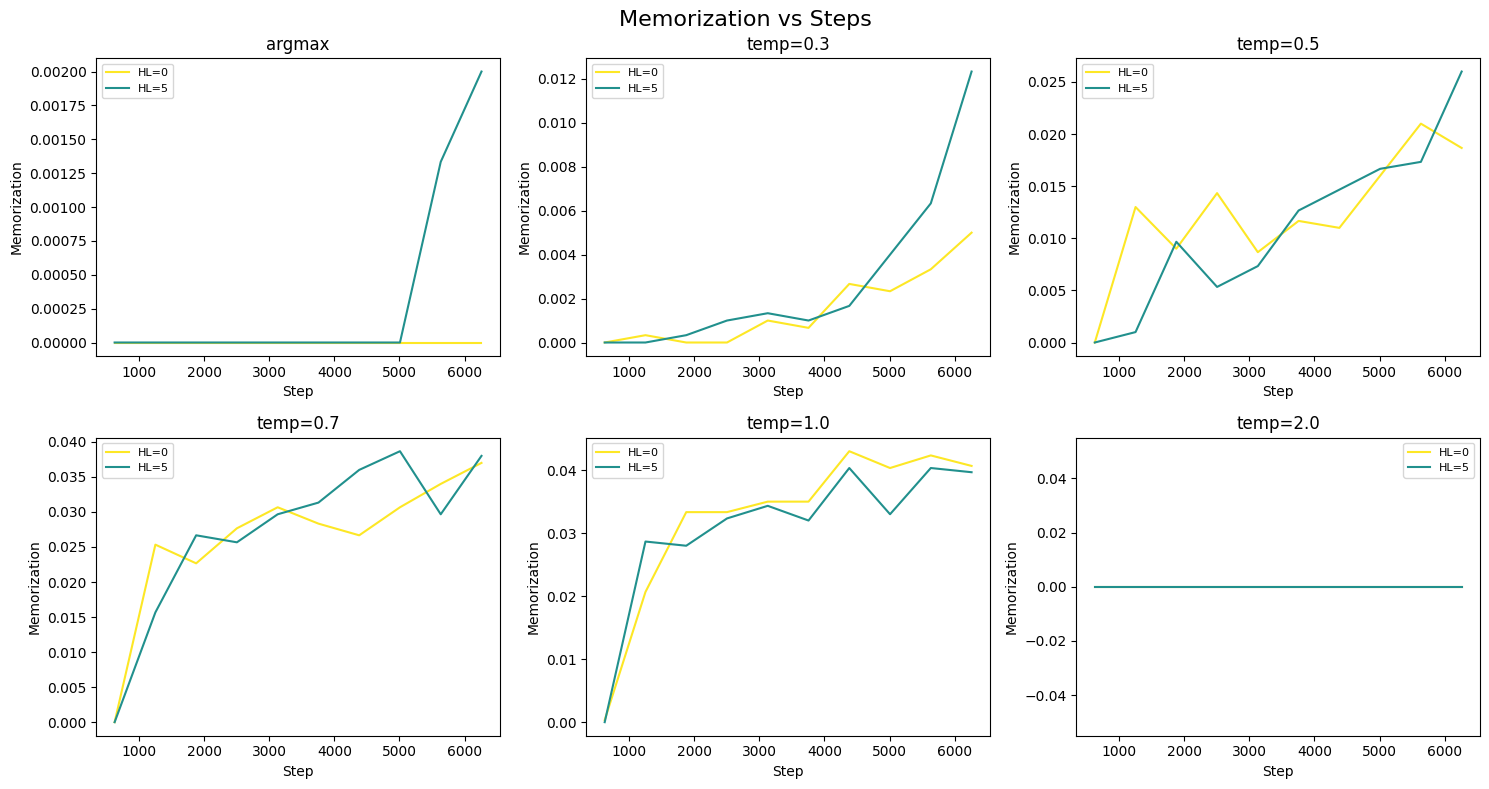

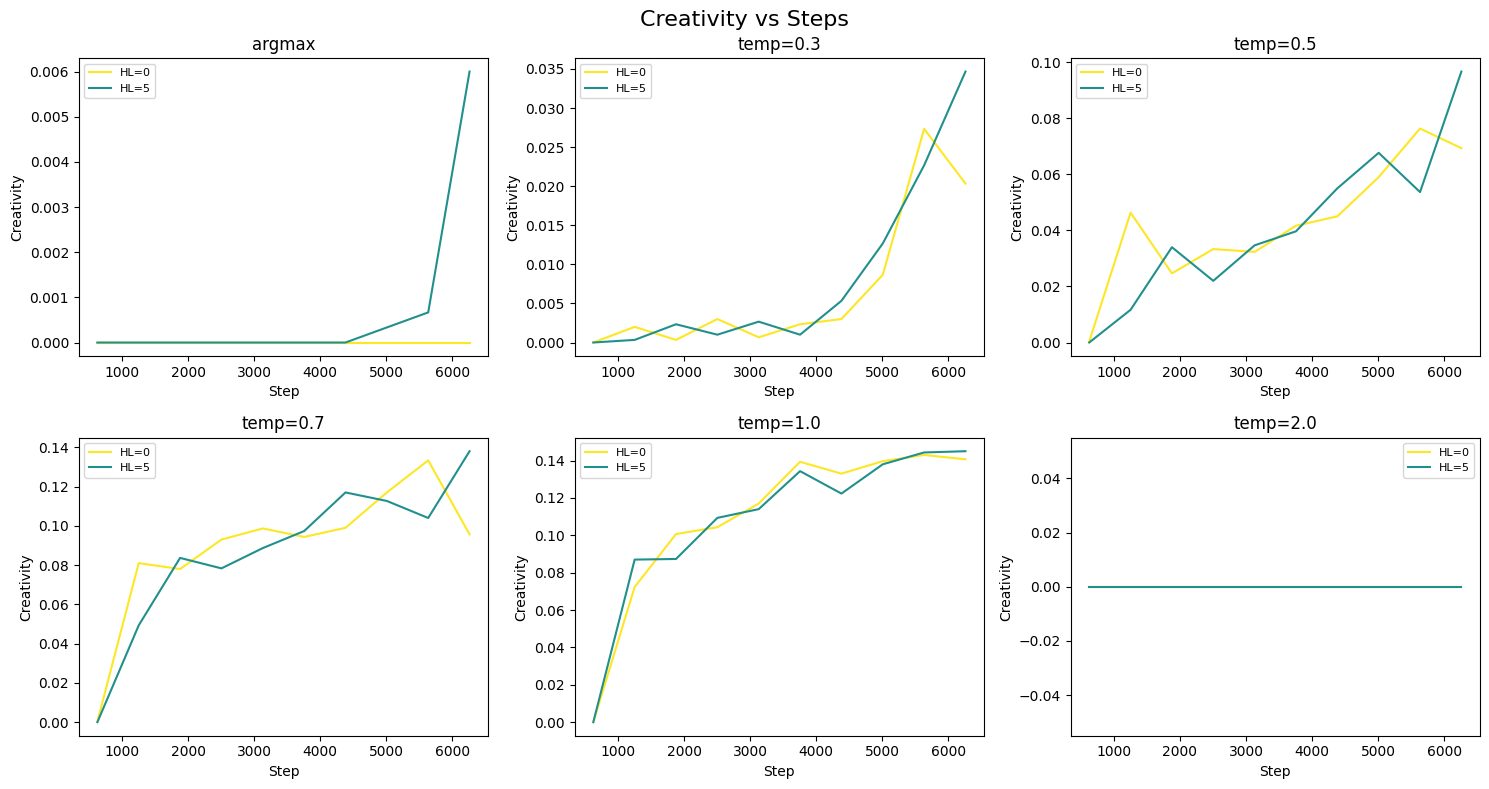

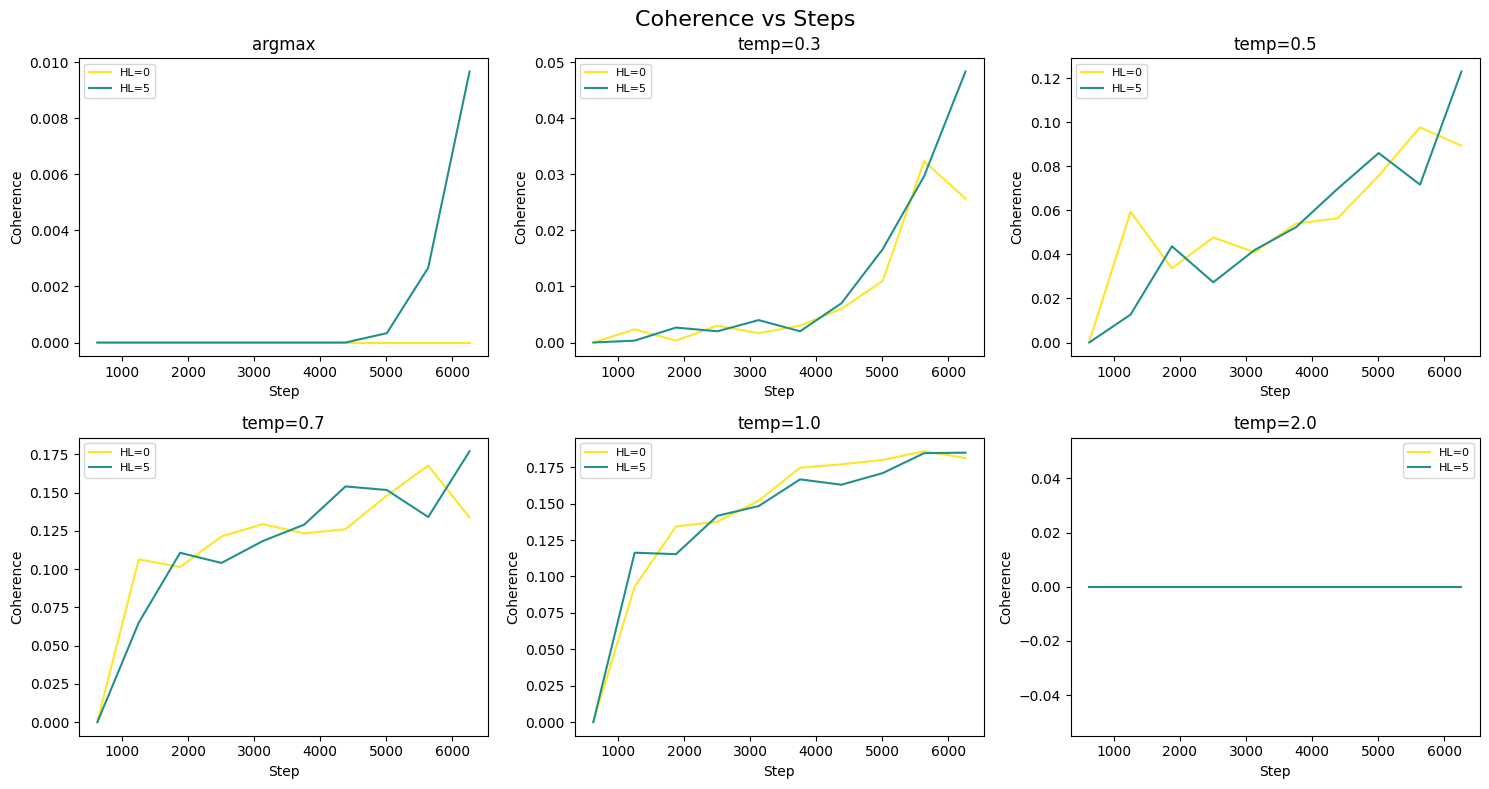

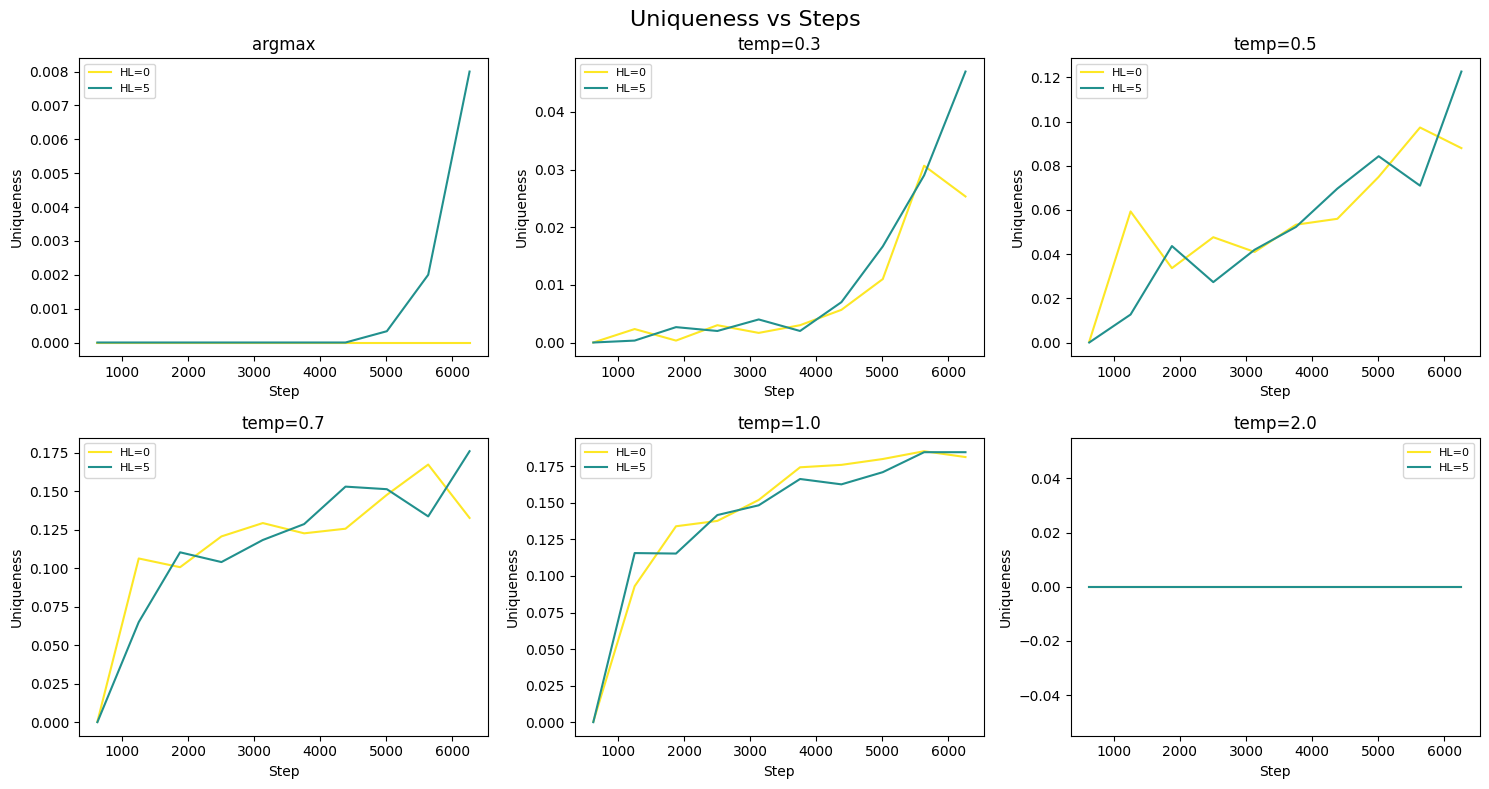

In [7]:
data_dir = "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H200-NT10000-E200-top_p1.0-gpt2-large"  # Change this if needed

# data_dir = "./sibling_discovery/results/P5-C2500-prob1-H26-N50000-E30-new_eval_no_logit_processor-plan"  # Change this if needed
plot_metric_with_subplots("rep_power", "Memorization", "Memorization vs Steps", data_dir)
plot_metric_with_subplots("creativity", "Creativity", "Creativity vs Steps", data_dir)
plot_metric_with_subplots("coherence", "Coherence", "Coherence vs Steps", data_dir)
plot_metric_with_subplots("uniqueness", "Uniqueness", "Uniqueness vs Steps", data_dir)
# plot_metric_with_subplots("perplexity", "Perplexity", "Perplexity vs Steps", data_dir)

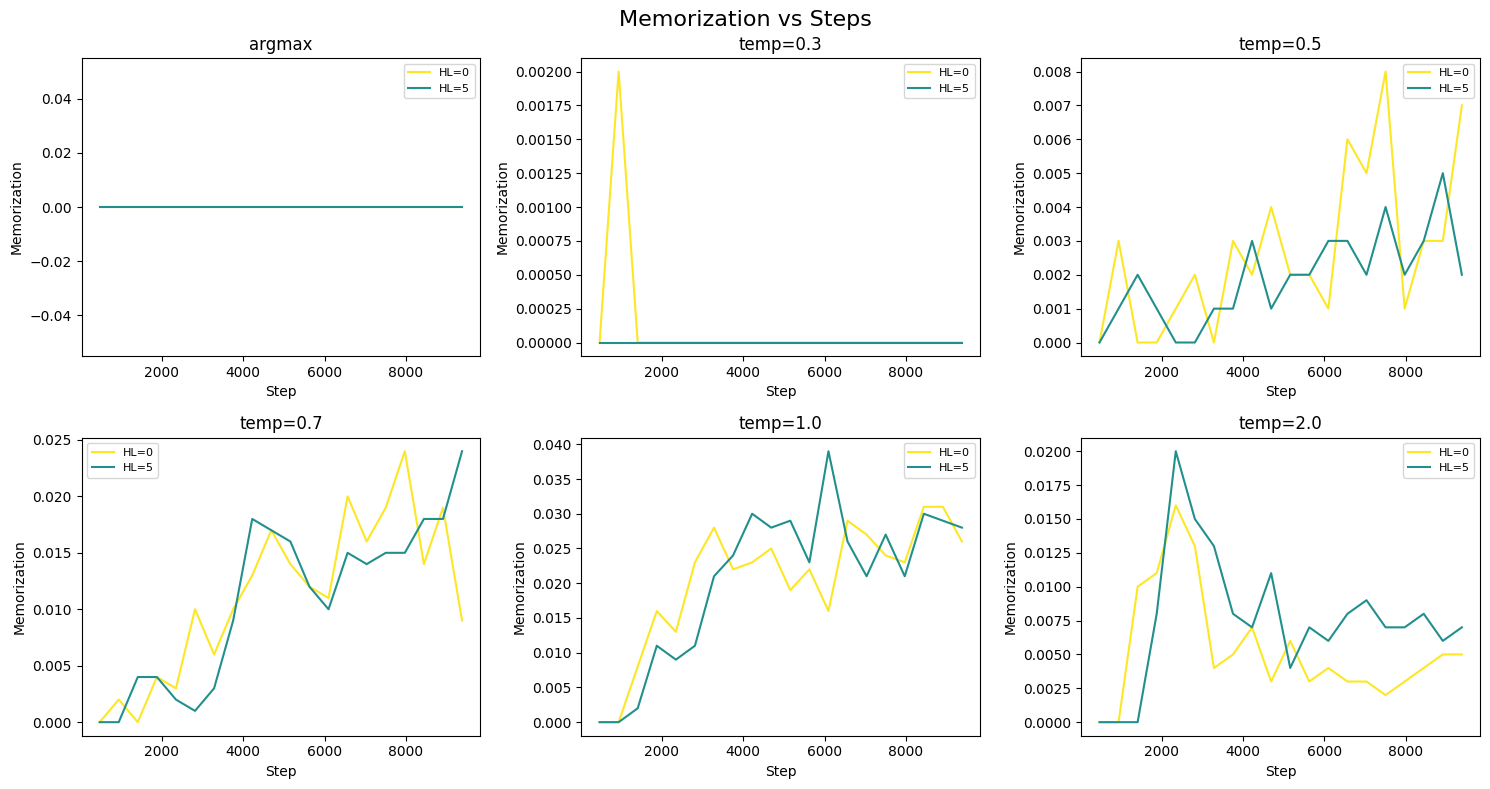

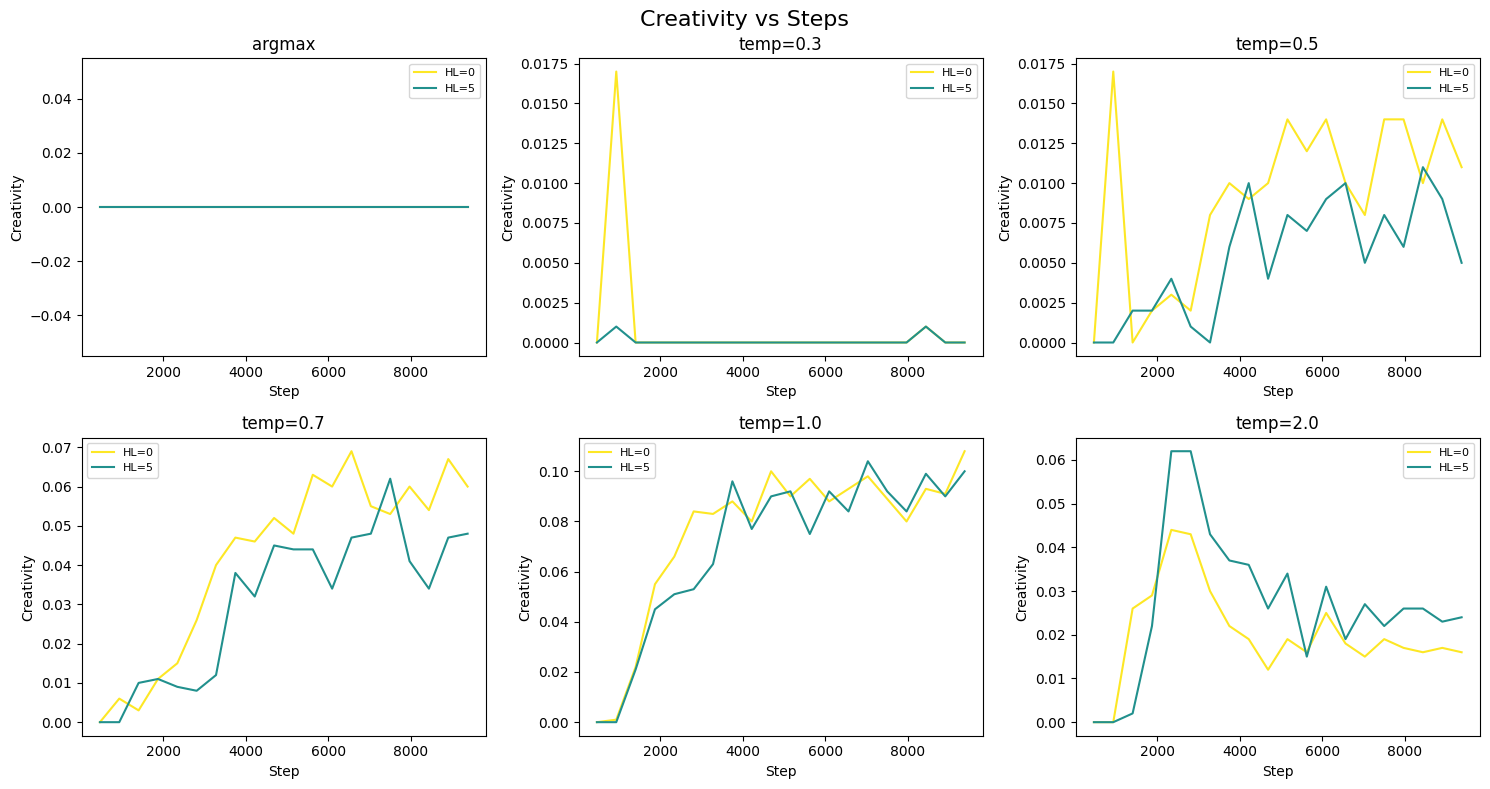

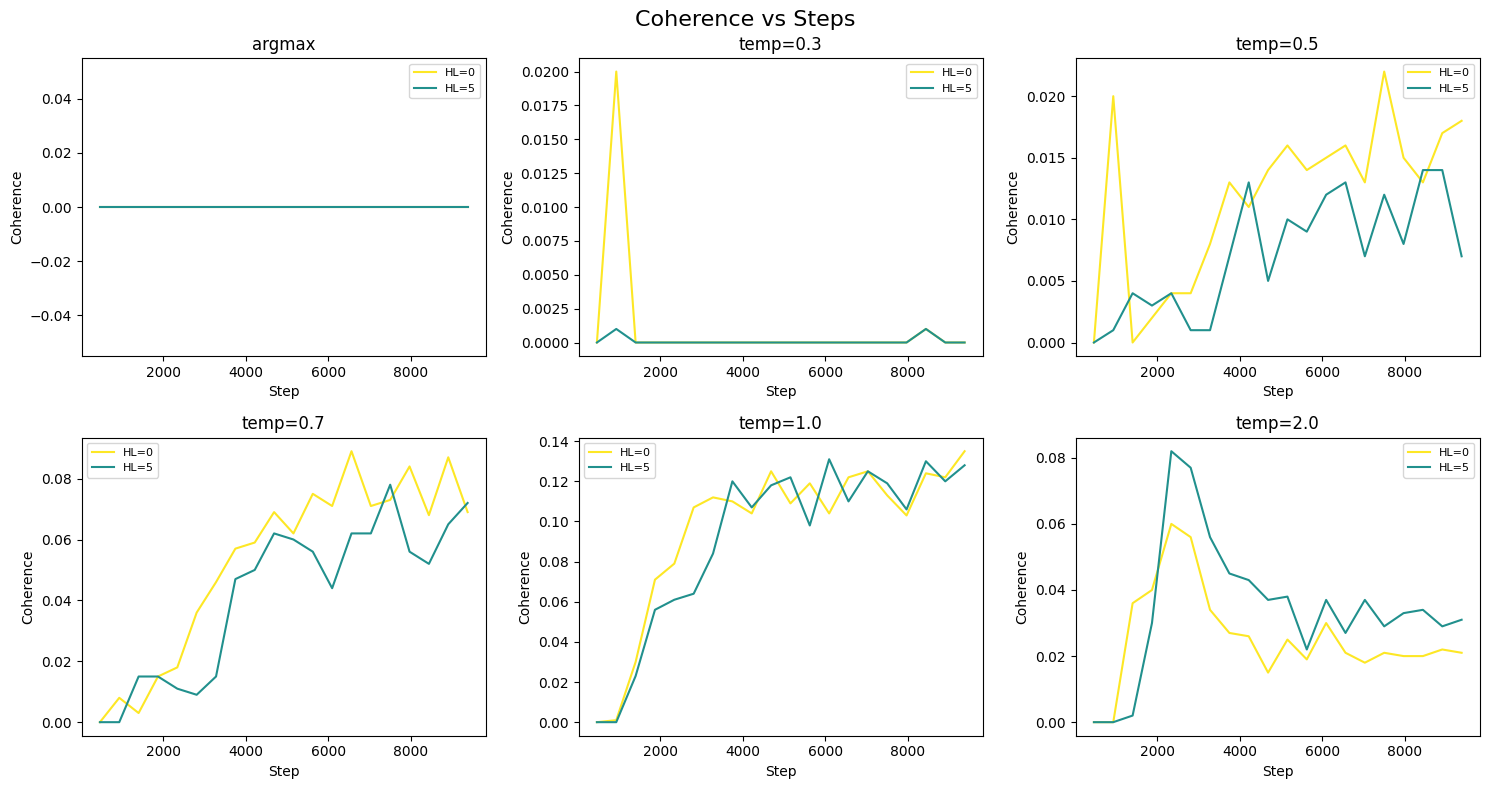

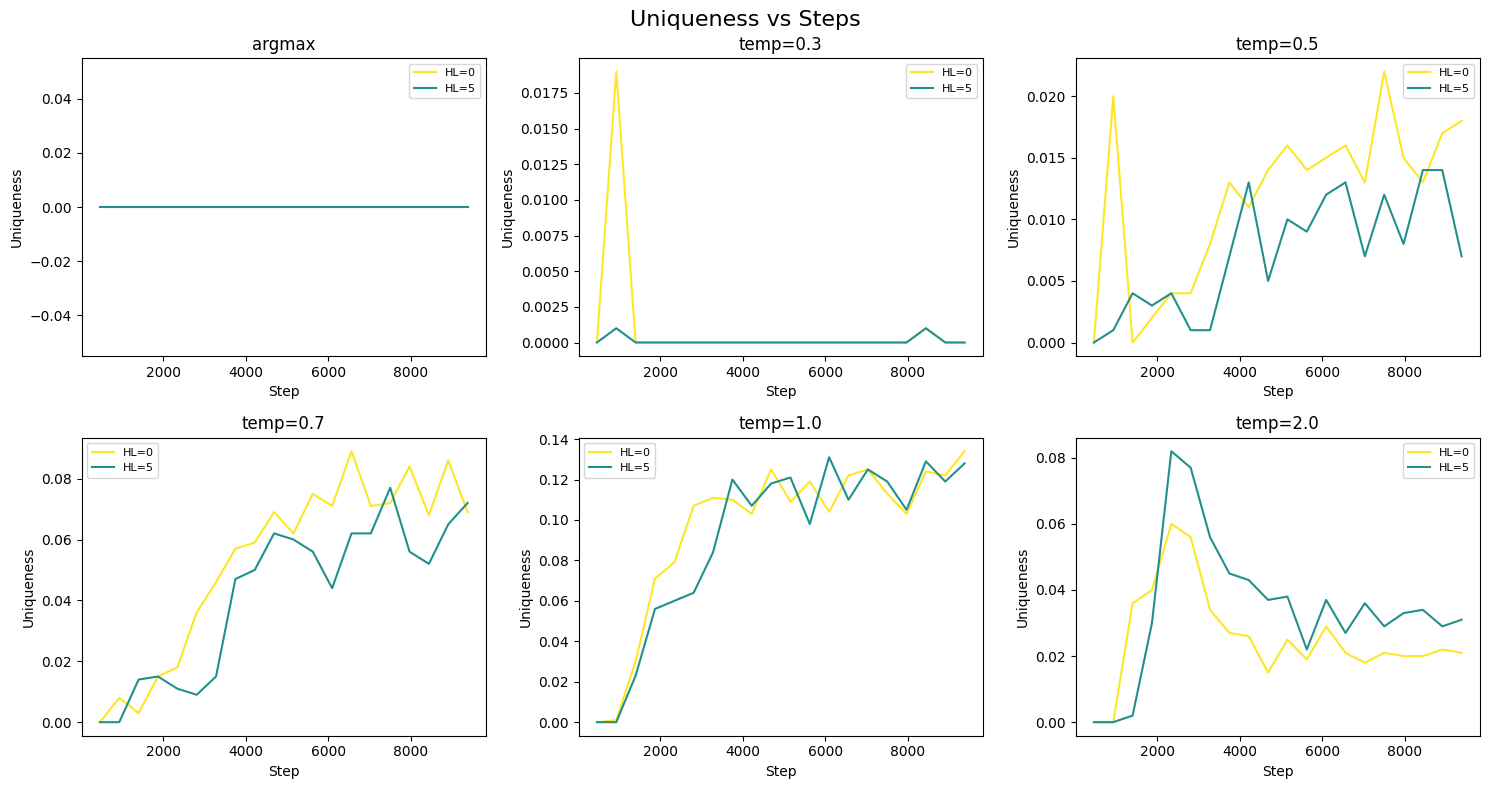

In [6]:
data_dir = "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-E30-top_p1.0-attention-only-12"  # Change this if needed

# data_dir = "./sibling_discovery/results/P5-C2500-prob1-H26-N50000-E30-new_eval_no_logit_processor-plan"  # Change this if needed
plot_metric_with_subplots("rep_power", "Memorization", "Memorization vs Steps", data_dir)
plot_metric_with_subplots("creativity", "Creativity", "Creativity vs Steps", data_dir)
plot_metric_with_subplots("coherence", "Coherence", "Coherence vs Steps", data_dir)
plot_metric_with_subplots("uniqueness", "Uniqueness", "Uniqueness vs Steps", data_dir)

In [4]:
import os
import json
import re
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Any

def extract_all_seed_lengths(data_dirs: List[str]) -> List[int]:
    """
    Scans all provided directories and returns a sorted, unique list of all
    seed lengths found in the filenames (e.g., HL4.json -> 4).
    """
    all_seed_lengths = set()
    pattern = re.compile(r"HL(\d+)\.json")
    for data_dir in data_dirs:
        if not os.path.isdir(data_dir):
            print(f"Warning: Directory not found, skipping: {data_dir}")
            continue
        for filename in os.listdir(data_dir):
            match = pattern.match(filename)
            if match:
                all_seed_lengths.add(int(match.group(1)))
    return sorted(list(all_seed_lengths))

def get_best_metrics_for_all_dirs(
    data_dirs: List[str], 
    seed_lengths: List[int], 
    metric_name: str
) -> Dict[str, Dict[int, Dict[str, Any]]]:
    """
    Processes all experiment directories to find the single best metric value 
    for each (directory, seed_length) pair. It compares the best 'argmax' result
    against the best 'softmax-temp' result and selects the overall winner.

    Returns:
        A nested dictionary: {dir_name: {seed_length: {value, method, epoch}}}
    """
    # Use the base directory name as the identifier for the experiment setting
    results = {os.path.basename(os.path.normpath(d)): {} for d in data_dirs}

    for data_dir in data_dirs:
        dir_name = os.path.basename(os.path.normpath(data_dir))
        for hl in seed_lengths:
            # Default values in case of missing data
            best_overall_value = -1.0
            best_overall_method = "N/A"
            best_overall_epoch = -1

            file_path = os.path.join(data_dir, f"HL{hl}.json")
            if os.path.exists(file_path):
                with open(file_path, "r") as f:
                    data = json.load(f)

                # Find best argmax value
                max_argmax = -1.0
                argmax_epoch = -1
                for epoch_str, epoch_data in data.items():
                    if "argmax" in epoch_data:
                        val = epoch_data["argmax"].get(f"{metric_name}_mean", -1.0)
                        if val > max_argmax:
                            max_argmax = val
                            argmax_epoch = int(epoch_str)

                # Find best softmax-temp value
                max_softmax = -1.0
                softmax_temp_label = "N/A"
                softmax_epoch = -1
                for epoch_str, epoch_data in data.items():
                    for key, val_dict in epoch_data.items():
                        if key.startswith("temp="):
                            val = val_dict.get(f"{metric_name}_mean", -1.0)
                            if val > max_softmax:
                                max_softmax = val
                                softmax_temp_label = key
                                softmax_epoch = int(epoch_str)
                
                # Compare and determine the single best result
                if max_argmax > max_softmax:
                    best_overall_value = max_argmax
                    best_overall_method = "argmax"
                    best_overall_epoch = argmax_epoch
                elif max_softmax > -1.0: # Check if softmax found any valid data
                    best_overall_value = max_softmax
                    best_overall_method = softmax_temp_label
                    best_overall_epoch = softmax_epoch

            results[dir_name][hl] = {
                'value': best_overall_value,
                'method': best_overall_method,
                'epoch': best_overall_epoch
            }
            
    return results

def plot_grouped_barchart(
    results: Dict[str, Dict[int, Dict]], 
    seed_lengths: List[int], 
    metric_name: str,
    ylabel: str,
    experiment_title,
    legend_labels
):
    """
    Creates and displays a grouped bar chart comparing the best metric values
    from different experiment directories across various seed lengths.
    """
    dir_names = list(results.keys())
    num_dirs = len(dir_names)
    x = np.arange(len(seed_lengths))  # the label locations
    width = 0.8 / num_dirs  # the width of the bars, with some padding

    fig, ax = plt.subplots(figsize=(8 + num_dirs * 1.5, 6))

    for i, dir_name in enumerate(dir_names):
        offset = (i - (num_dirs - 1) / 2) * width
        
        # Get original values, with -1.0 indicating missing data
        original_values = [results[dir_name].get(hl, {}).get('value', -1.0) for hl in seed_lengths]
        
        # For plotting, replace missing values (-1.0) with 0 so bars don't go negative
        plot_values = [v if v >= 0 else 0 for v in original_values]
        
        # Create custom labels: format valid numbers, use "N/A" for missing ones
        labels = [f"{v:.3f}" if v >= 0 else "N/A" for v in original_values]
        
        rects = ax.bar(x + offset, plot_values, width, label=legend_labels[i] if legend_labels else dir_name)
        
        # Apply the custom labels to the bars
        ax.bar_label(rects, labels=labels, padding=3, fontsize=8)

    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel("Seed Length", fontsize=12)
    ax.set_title(f"Best '{metric_name}' Performance {experiment_title}", fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(seed_lengths)
    ax.legend(title="Experiment Settings", bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    fig.tight_layout()
    plt.show()

def display_results_table(
    results: Dict[str, Dict[int, Dict]],
    seed_lengths: List[int],
    metric_name: str
):
    """
    Prints a formatted text table to the console summarizing the best metric
    values, methods, and epochs for each experiment setting and seed length.
    """
    dir_names = list(results.keys())
    
    # Prepare header and data rows
    header = ["Seed Length"] + dir_names
    rows = []
    for hl in seed_lengths:
        row_data = [f"HL={hl}"]
        for dir_name in dir_names:
            data = results[dir_name].get(hl, {})
            val = data.get('value', -1.0)
            method = data.get('method', 'N/A')
            epoch = data.get('epoch', -1)
            cell_str = f"{val:.3f} ({method} @ {epoch})" if val >= 0 else "N/A"
            row_data.append(cell_str)
        rows.append(row_data)

    # Calculate column widths for alignment
    col_widths = [len(h) for h in header]
    for row in rows:
        for i, cell in enumerate(row):
            if len(cell) > col_widths[i]:
                col_widths[i] = len(cell)

    # --- Print the table ---
    title = f"--- Summary Table for Best '{metric_name}' ---"
    print("\n" + title)
    
    # Print header
    header_line = " | ".join(header[i].ljust(col_widths[i]) for i in range(len(header)))
    print(header_line)
    
    # Print separator
    separator = "-+-".join("-" * w for w in col_widths)
    print(separator)

    # Print data rows
    for row in rows:
        row_line = " | ".join(row[i].ljust(col_widths[i]) for i in range(len(row)))
        print(row_line)
    print("-" * len(separator)) # Footer line


In [5]:
data_dirs = [
    # "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-E100-top_p1.0-gpt2-pretrained-BS32-LR5e-5-RNG20"
    # "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-E200-top_p1.0-gpt2-pretrained-BS32-LR1e-4-RNG20"
    "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-E200-top_p1.0-gpt2-large-pretrained-BS32-LR5e-5-RNG20"
]
seed_lengths = extract_all_seed_lengths(data_dirs)
metric_name = "creativity"
results = get_best_metrics_for_all_dirs(data_dirs, seed_lengths, metric_name)
display_results_table(results, seed_lengths, metric_name)

metric_name = "rep_power"
results = get_best_metrics_for_all_dirs(data_dirs, seed_lengths, metric_name)
display_results_table(results, seed_lengths, metric_name)


--- Summary Table for Best 'creativity' ---
Seed Length | M15-N9-H26-NT10000-E200-top_p1.0-gpt2-large-pretrained-BS32-LR5e-5-RNG20
------------+-------------------------------------------------------------------------
HL=0        | 0.491 (temp=0.3 @ 3130)                                                 
HL=20       | 0.429 (temp=0.3 @ 3130)                                                 
--------------------------------------------------------------------------------------

--- Summary Table for Best 'rep_power' ---
Seed Length | M15-N9-H26-NT10000-E200-top_p1.0-gpt2-large-pretrained-BS32-LR5e-5-RNG20
------------+-------------------------------------------------------------------------
HL=0        | 0.914 (temp=0.7 @ 25666)                                                
HL=20       | 0.907 (temp=0.7 @ 20032)                                                
--------------------------------------------------------------------------------------


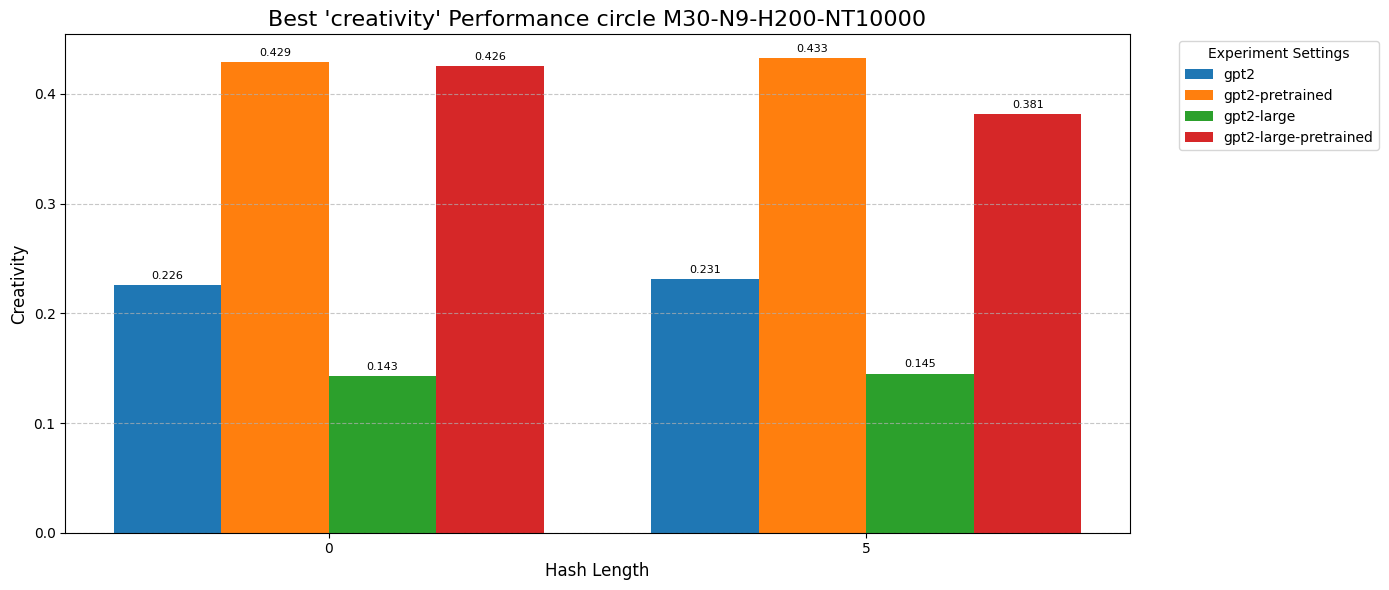


--- Summary Table for Best 'creativity' ---
Hash Length | M15-N9-H200-NT10000-E200-top_p1.0-gpt2 | M15-N9-H200-NT10000-E200-top_p1.0-gpt2-pretrained | M15-N9-H200-NT10000-E200-top_p1.0-gpt2-large | M15-N9-H200-NT10000-E200-top_p1.0-gpt2-large-pretrained
------------+----------------------------------------+---------------------------------------------------+----------------------------------------------+--------------------------------------------------------
HL=0        | 0.226 (temp=0.5 @ 15024)               | 0.429 (temp=0.3 @ 10642)                          | 0.143 (temp=1.0 @ 5634)                      | 0.426 (temp=0.3 @ 3130)                                
HL=5        | 0.231 (temp=0.7 @ 14398)               | 0.433 (temp=0.3 @ 12520)                          | 0.145 (temp=1.0 @ 6260)                      | 0.381 (temp=0.3 @ 3130)                                
-------------------------------------------------------------------------------------------------------------------

In [ ]:
# M30-N9-H200-NT10000

data_dirs = [
    "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H200-NT10000-E200-top_p1.0-gpt2",
    "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H200-NT10000-E200-top_p1.0-gpt2-pretrained",
    "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H200-NT10000-E200-top_p1.0-gpt2-large",
    "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H200-NT10000-E200-top_p1.0-gpt2-large-pretrained",
    ]
legend_labels = [
    "gpt2",
    "gpt2-pretrained",
    "gpt2-large",
    "gpt2-large-pretrained",
    "gpt2-unique_seed_per_pi"
]
seed_lengths = extract_all_seed_lengths(data_dirs)
metric_name = "creativity"
results = get_best_metrics_for_all_dirs(data_dirs, seed_lengths, metric_name)
plot_grouped_barchart(results, seed_lengths, metric_name, "Creativity", experiment_title="circle M30-N9-H200-NT10000", legend_labels=legend_labels)
display_results_table(results, seed_lengths, metric_name)

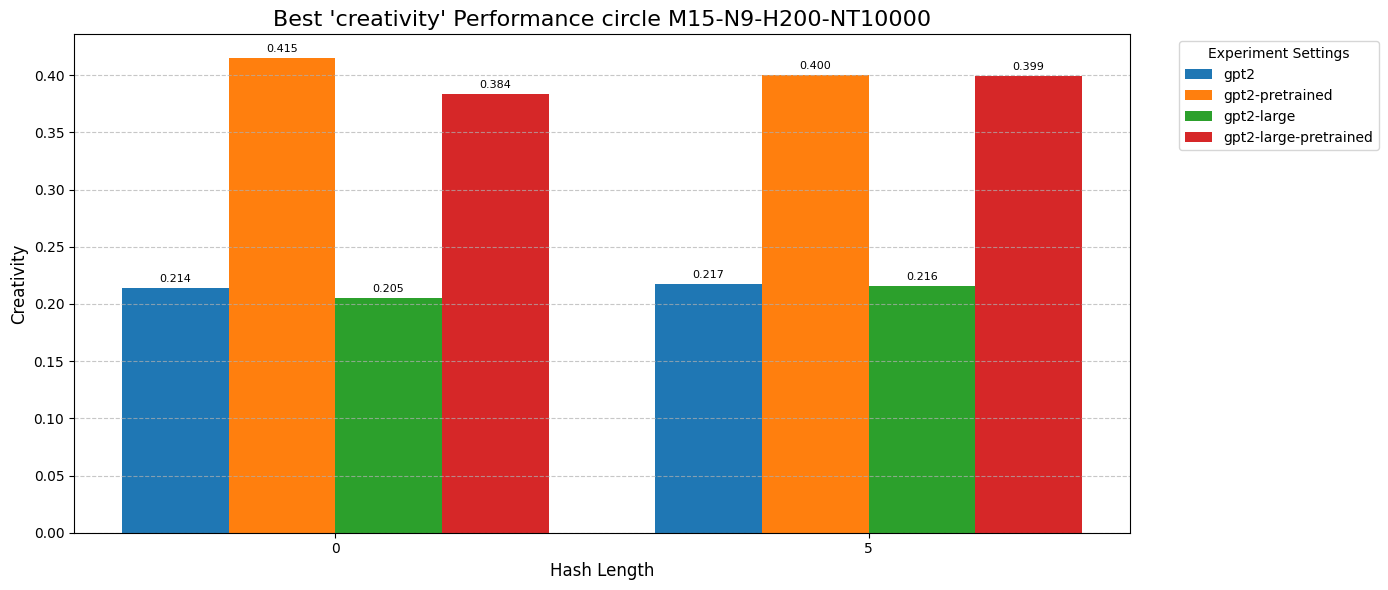


--- Summary Table for Best 'creativity' ---
Hash Length | M30-N9-H200-NT10000-E200-top_p1.0-gpt2 | M30-N9-H200-NT10000-E200-top_p1.0-gpt2-pretrained | M30-N9-H200-NT10000-E200-top_p1.0-gpt2-large | M30-N9-H200-NT10000-E200-top_p1.0-gpt2-large-pretrained
------------+----------------------------------------+---------------------------------------------------+----------------------------------------------+--------------------------------------------------------
HL=0        | 0.214 (temp=0.7 @ 5634)                | 0.415 (temp=0.5 @ 11894)                          | 0.205 (temp=0.7 @ 6260)                      | 0.384 (temp=0.5 @ 3130)                                
HL=5        | 0.217 (temp=0.5 @ 8138)                | 0.400 (temp=0.7 @ 13772)                          | 0.216 (temp=0.3 @ 10016)                     | 0.399 (temp=0.5 @ 3130)                                
-------------------------------------------------------------------------------------------------------------------

In [ ]:
# M30-N9-H200-NT10000

data_dirs = [
    "/datastor1/vansh/lang_sampling/results/circle/M30-N9-H200-NT10000-E200-top_p1.0-gpt2",
    "/datastor1/vansh/lang_sampling/results/circle/M30-N9-H200-NT10000-E200-top_p1.0-gpt2-pretrained",
    "/datastor1/vansh/lang_sampling/results/circle/M30-N9-H200-NT10000-E200-top_p1.0-gpt2-large",
    "/datastor1/vansh/lang_sampling/results/circle/M30-N9-H200-NT10000-E200-top_p1.0-gpt2-large-pretrained",
    ]
legend_labels = [
    "gpt2",
    "gpt2-pretrained",
    "gpt2-large",
    "gpt2-large-pretrained",
    "gpt2-unique_seed_per_pi"
]
seed_lengths = extract_all_seed_lengths(data_dirs)
metric_name = "creativity"
results = get_best_metrics_for_all_dirs(data_dirs, seed_lengths, metric_name)
plot_grouped_barchart(results, seed_lengths, metric_name, "Creativity", experiment_title="circle M30-N9-H200-NT10000", legend_labels=legend_labels)
display_results_table(results, seed_lengths, metric_name)

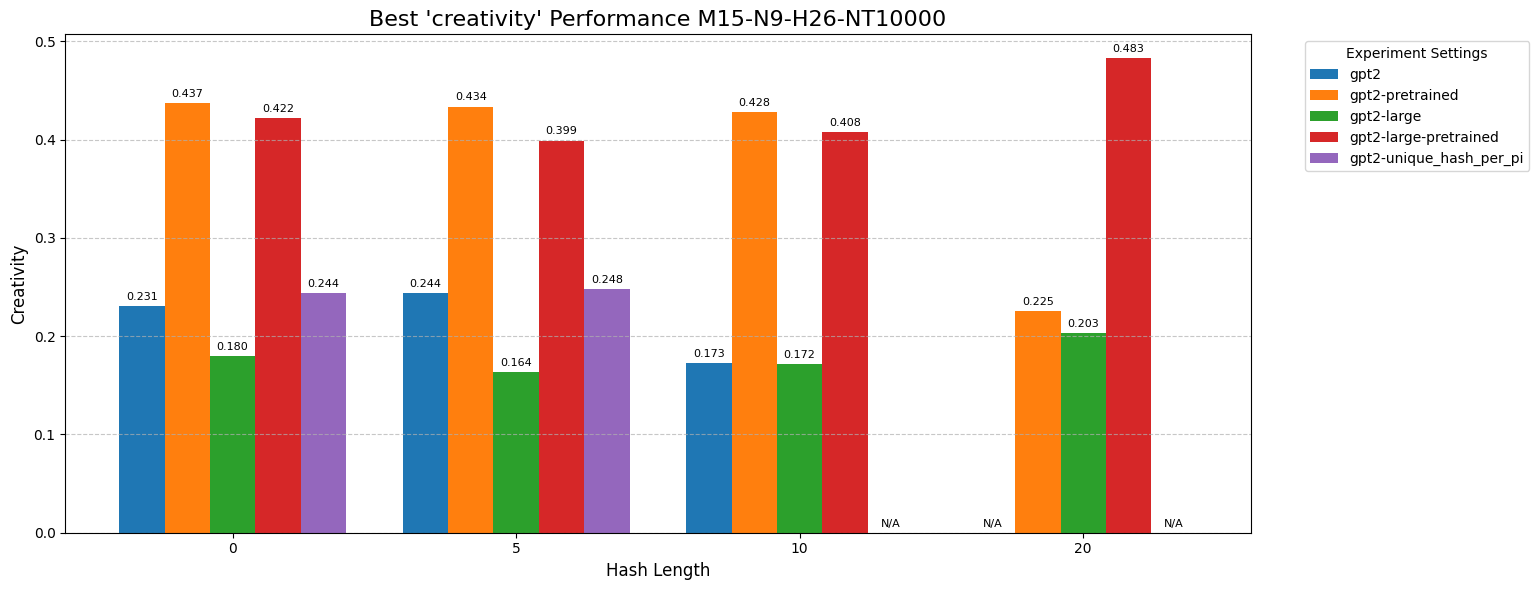


--- Summary Table for Best 'creativity' ---
Hash Length | M15-N9-H26-NT10000-E200-top_p1.0-gpt2 | M15-N9-H26-NT10000-E200-top_p1.0-gpt2-pretrained | M15-N9-H26-NT10000-E100-top_p1.0-gpt2-large | M15-N9-H26-NT10000-E100-top_p1.0-gpt2-large-pretrained | M15-N9-H26-NT10000-E200-top_p1.0-gpt2-hash_per_pi
------------+---------------------------------------+--------------------------------------------------+---------------------------------------------+--------------------------------------------------------+--------------------------------------------------
HL=0        | 0.231 (temp=1.0 @ 15650)              | 0.437 (temp=0.5 @ 10642)                         | 0.180 (temp=0.7 @ 3925)                     | 0.422 (temp=0.3 @ 1884)                                | 0.244 (temp=0.5 @ 13146)                         
HL=5        | 0.244 (temp=0.7 @ 14398)              | 0.434 (temp=0.5 @ 12520)                         | 0.164 (temp=1.0 @ 6594)                     | 0.399 (temp=0.3 @ 1570)       

In [ ]:
# M15-N9-H26-NT10000

data_dirs = [
    "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-E200-top_p1.0-gpt2",
    "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-E200-top_p1.0-gpt2-pretrained",
    "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-E100-top_p1.0-gpt2-large",
    "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-E100-top_p1.0-gpt2-large-pretrained",
    "/datastor1/vansh/lang_sampling/results/circle/M15-N9-H26-NT10000-E200-top_p1.0-gpt2-seed_per_pi"
    ]
legend_labels = [
    "gpt2",
    "gpt2-pretrained",
    "gpt2-large",
    "gpt2-large-pretrained",
    "gpt2-unique_seed_per_pi"
]
seed_lengths = extract_all_seed_lengths(data_dirs)
metric_name = "creativity"
results = get_best_metrics_for_all_dirs(data_dirs, seed_lengths, metric_name)
plot_grouped_barchart(results, seed_lengths, metric_name, "Creativity", experiment_title="M15-N9-H26-NT10000", legend_labels=legend_labels)
display_results_table(results, seed_lengths, metric_name)

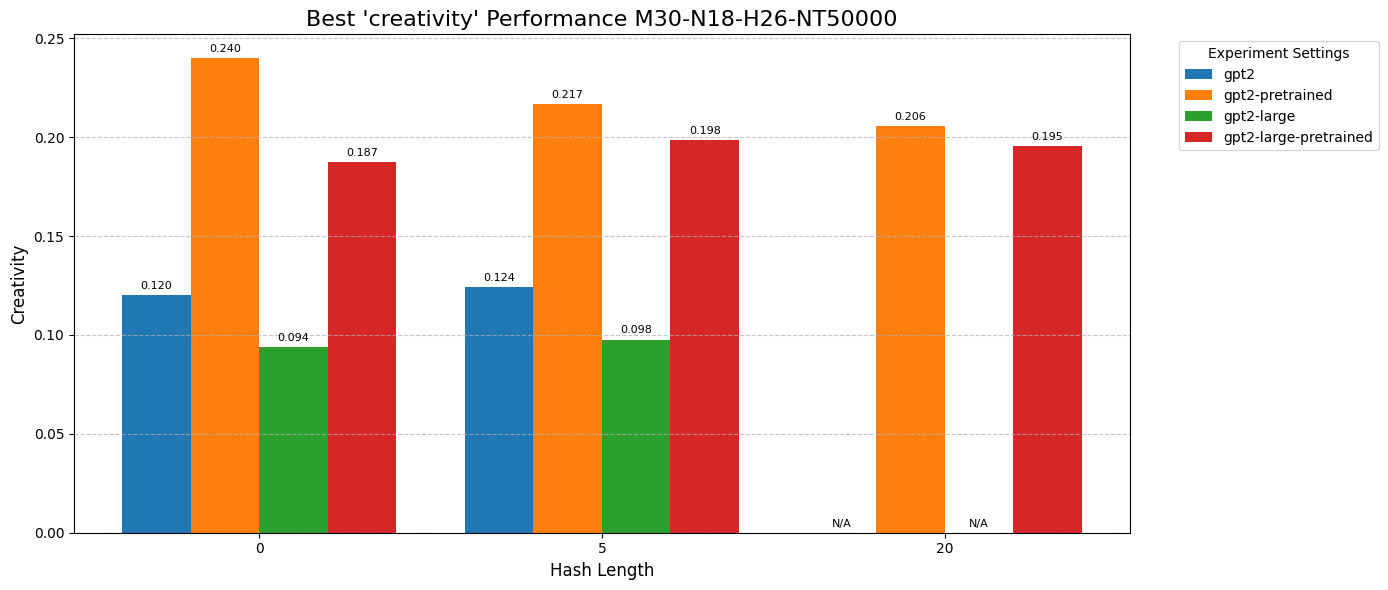


--- Summary Table for Best 'creativity' ---
Hash Length | M30-N18-H26-NT50000-E300-top_p1.0-gpt2 | M30-N18-H26-NT50000-E300-top_p1.0-gpt2-pretrained | M30-N18-H26-NT50000-E300-top_p1.0-gpt2-large | M30-N18-H26-NT50000-E300-top_p1.0-gpt2-large-pretrained
------------+----------------------------------------+---------------------------------------------------+----------------------------------------------+--------------------------------------------------------
HL=0        | 0.120 (temp=1.0 @ 37512)               | 0.240 (temp=0.1 @ 89091)                          | 0.094 (temp=1.0 @ 18756)                     | 0.187 (temp=0.1 @ 18756)                               
HL=5        | 0.124 (temp=1.0 @ 42201)               | 0.217 (temp=0.1 @ 60957)                          | 0.098 (temp=1.0 @ 18756)                     | 0.198 (temp=0.3 @ 37512)                               
HL=20       | N/A                                    | 0.206 (temp=0.3 @ 98469)                          | N/A     

In [ ]:
data_dirs = [
    "/datastor1/vansh/lang_sampling/results/circle/M30-N18-H26-NT50000-E300-top_p1.0-gpt2",
    "/datastor1/vansh/lang_sampling/results/circle/M30-N18-H26-NT50000-E300-top_p1.0-gpt2-pretrained",
    "/datastor1/vansh/lang_sampling/results/circle/M30-N18-H26-NT50000-E300-top_p1.0-gpt2-large",
    "/datastor1/vansh/lang_sampling/results/circle/M30-N18-H26-NT50000-E300-top_p1.0-gpt2-large-pretrained",
    ]

legend_labels = [
    "gpt2",
    "gpt2-pretrained",
    "gpt2-large",
    "gpt2-large-pretrained",
    ]

seed_lengths = extract_all_seed_lengths(data_dirs)
metric_name = "creativity"
results = get_best_metrics_for_all_dirs(data_dirs, seed_lengths, metric_name)
plot_grouped_barchart(results, seed_lengths, metric_name, "Creativity", experiment_title="M30-N18-H26-NT50000", legend_labels=legend_labels)
display_results_table(results, seed_lengths, metric_name)

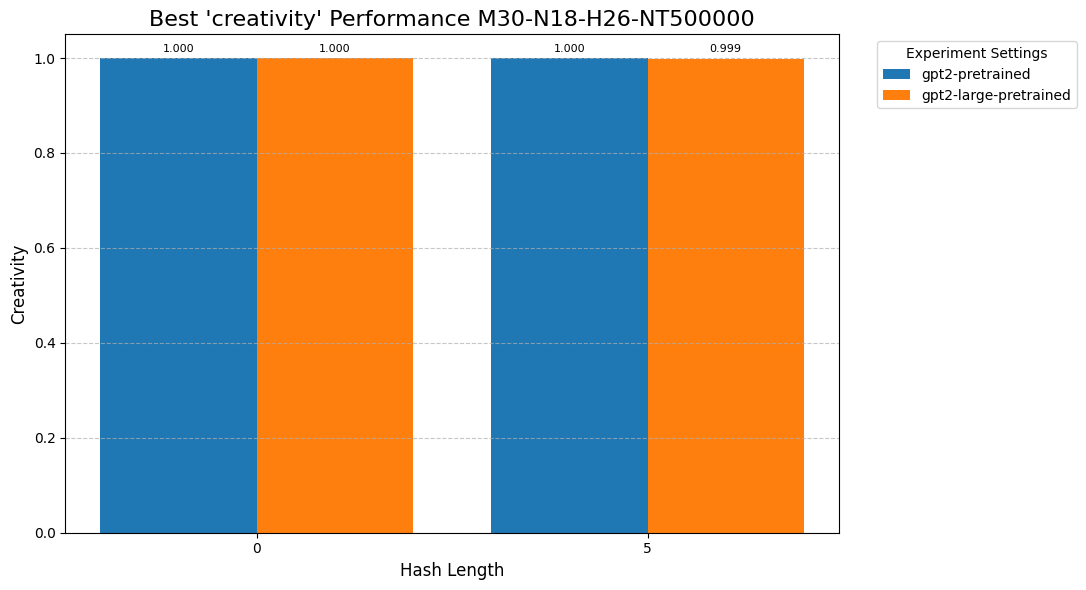


--- Summary Table for Best 'creativity' ---
Hash Length | M30-N18-H26-NT500000-E50-top_p1.0-gpt2-pretrained-2 | M30-N18-H26-NT500000-E50-top_p1.0-gpt2-large-pretrained
------------+-----------------------------------------------------+--------------------------------------------------------
HL=0        | 1.000 (temp=0.5 @ 640584)                           | 1.000 (temp=0.5 @ 187488)                              
HL=5        | 1.000 (temp=0.5 @ 396459)                           | 0.999 (temp=0.3 @ 228501)                              
---------------------------------------------------------------------------------------------------------------------------


In [ ]:
data_dirs = [
    "/datastor1/vansh/lang_sampling/results/circle/M30-N18-H26-NT500000-E50-top_p1.0-gpt2-pretrained-2",
    "/datastor1/vansh/lang_sampling/results/circle/M30-N18-H26-NT500000-E50-top_p1.0-gpt2-large-pretrained"
    ]
legend_labels = [
    "gpt2-pretrained",
    "gpt2-large-pretrained"
]
seed_lengths = extract_all_seed_lengths(data_dirs)
metric_name = "creativity"
results = get_best_metrics_for_all_dirs(data_dirs, seed_lengths, metric_name)
plot_grouped_barchart(results, seed_lengths, metric_name, "Creativity", experiment_title="M30-N18-H26-NT500000", legend_labels=legend_labels)
display_results_table(results, seed_lengths, metric_name)

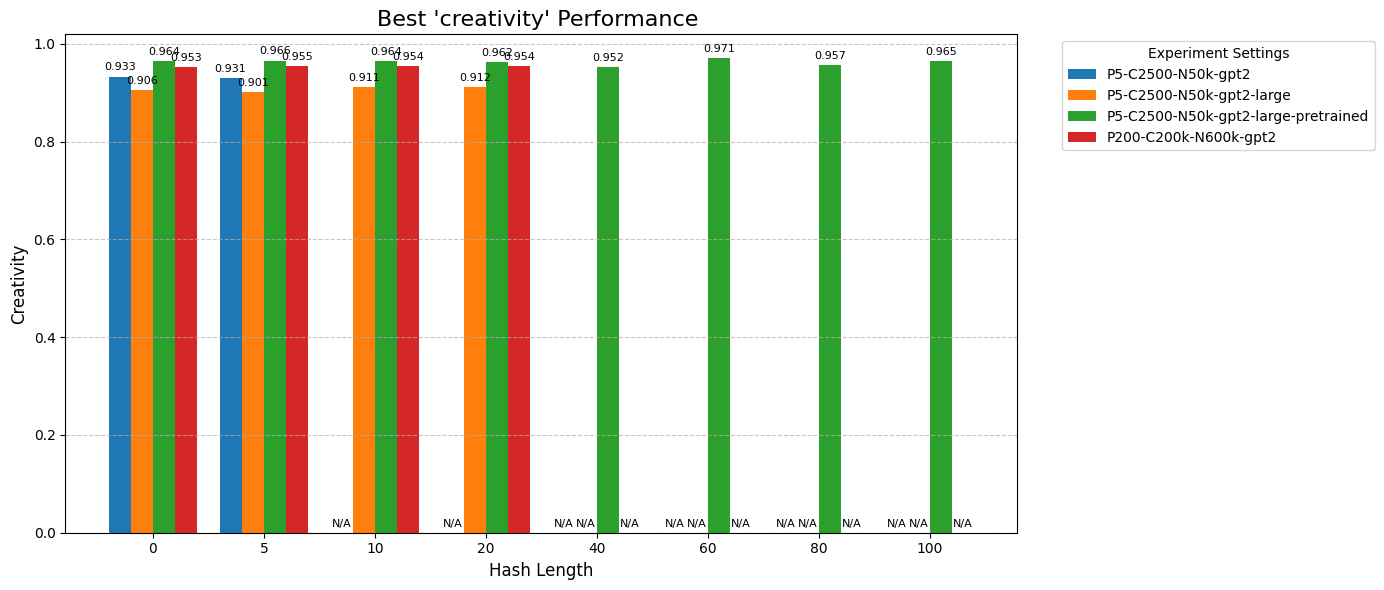


--- Summary Table for Best 'creativity' ---
Hash Length | P5-C2500-prob1-H26-N50000-E70-top_p1.0-gpt2-plan | P5-C2500-prob1-H26-N50000-E100-top_p1.0-gpt_l-plan | P5-C2500-prob1-H26-N50000-E100-top_p1.0-gpt2-large-pretrained-plan | P200-C200000-prob1-H26-N600000-E30-plan
------------+--------------------------------------------------+----------------------------------------------------+--------------------------------------------------------------------+----------------------------------------
HL=0        | 0.933 (temp=0.5 @ 6564)                          | 0.906 (temp=0.7 @ 7038)                            | 0.964 (temp=0.7 @ 18750)                                           | 0.953 (temp=0.5 @ 92796)               
HL=5        | 0.931 (temp=0.5 @ 7111)                          | 0.901 (temp=0.5 @ 3910)                            | 0.966 (temp=0.5 @ 6250)                                            | 0.955 (temp=0.3 @ 84360)               
HL=10       | N/A                              

In [ ]:
data_dirs = [
    "/datastor1/vansh/lang_sampling/results/sibling/P5-C2500-prob1-H26-N50000-E70-top_p1.0-gpt2-plan",
    "/datastor1/vansh/lang_sampling/old_results/sibling/P5-C2500-prob1-H26-N50000-E100-top_p1.0-gpt_l-plan",
    "/datastor1/vansh/lang_sampling/results/sibling/P5-C2500-prob1-H26-N50000-E100-top_p1.0-gpt2-large-pretrained-plan",
    "/datastor1/vansh/lang_sampling/old_results/sibling/P200-C200000-prob1-H26-N600000-E30-plan"
    ]
legend_labels = [
    "P5-C2500-N50k-gpt2",
    "P5-C2500-N50k-gpt2-large",
    # "gpt2-large",
    "P5-C2500-N50k-gpt2-large-pretrained",
    "P200-C200k-N600k-gpt2"
    # "gpt2-unique_seed_per_pi"
]
seed_lengths = extract_all_seed_lengths(data_dirs)
metric_name = "creativity"
results = get_best_metrics_for_all_dirs(data_dirs, seed_lengths, metric_name)
plot_grouped_barchart(results, seed_lengths, metric_name, "Creativity", experiment_title="", legend_labels=legend_labels)
display_results_table(results, seed_lengths, metric_name)